### 1. Introduction

#### 1.1. Contexte : Le Problème de la Fiabilité Algorithmique

En informatique, de nombreux problèmes fondamentaux, tels que le tri d'une liste, sont de nature déterministe. Pourtant, l'efficacité de nombreux algorithmes déterministes classiques dépend fortement de la structure des données d'entrée. L'algorithme de tri rapide (Quicksort), par exemple, est réputé pour son excellente performance moyenne en $O(n \log n)$, mais sa version déterministe (choisissant systématiquement le premier élément comme pivot) voit ses performances s'effondrer en $O(n^2)$ lorsqu'on lui présente une entrée déjà triée ou triée en ordre inverse. Cette vulnérabilité à des "pires cas" spécifiques est un obstacle majeur en ingénierie logicielle, où l'on ne peut garantir la nature des données d'entrée.

#### 1.2. La Randomisation comme Solution

Pour résoudre ce problème, l'informatique théorique a introduit la **randomisation** comme un outil de conception algorithmique. L'idée paradoxale est d'utiliser l'aléa pour résoudre un problème qui ne l'est pas.

En introduisant des choix aléatoires dans le processus de décision de l'algorithme (par exemple, le choix du pivot dans Quicksort), on s'affranchit de la structure de l'entrée. La performance de l'algorithme ne dépend plus de l'ordre initial des données, mais uniquement des tirages aléatoires effectués. Le "pire cas" ne disparaît pas, mais il n'est plus lié à une entrée pathologique ; il devient un événement probabiliste dont on peut borner la (faible) probabilité d'occurrence. L'objectif est d'assurer une performance moyenne élevée (une faible **espérance** de temps d'exécution) *quelle que soit* l'entrée fournie.

#### 1.3. Le Paradigme de Las Vegas

Cette approche s'inscrit dans le cadre des **algorithmes de Las Vegas**.
* **Principe :** Ils utilisent l'aléa pour guider leur exécution, mais garantissent que le résultat final est **toujours correct**.
* **Objectif :** Leur temps d'exécution est une variable aléatoire. L'objectif de l'analyse est de garantir que son *temps d'exécution attendu* (son espérance) est faible et maîtrisé.
* **Exemple Concret :** Le **Quicksort randomisé**, au cœur de ce rapport, est l'exemple canonique. En choisissant son pivot au hasard, il garantit un temps de tri moyen en $O(n \log n)$ pour n'importe quelle entrée. C'est cette robustesse qui en fait l'algorithme de tri de choix dans de nombreuses bibliothèques logicielles.

#### 1.4. Objectifs et Plan du Rapport

Ce rapport vise à analyser en profondeur ce paradigme de Las Vegas en s'appuyant sur les fondements théoriques de l'ouvrage "Probability and Computing" [[1]](#ref1).

Nous nous concentrerons sur la famille d'algorithmes **Quicksort** :
1.  Nous commencerons par analyser la complexité du **Quicksort randomisé** standard, en démontrant sa performance moyenne en $O(n \log n)$ par une analyse de récurrence.
2.  Nous étudierons ensuite l'optimisation **Median-of-Three Quicksort**, en analysant le gain théorique et en le validant par simulation.
3.  Enfin, nous étendrons cette analyse à l'algorithme de sélection **QuickSelect (QuickMedian)**, en démontrant sa complexité moyenne en $O(n)$ et en validant la constante asymptotique pour divers quantiles.

---
**Références :**

<a id="ref1"></a>[1] Mitzenmacher, M., & Upfal, E. (2005). *Probability and Computing*. Cambridge University Press.

<!-- PAGE_BREAK -->

### 2. Le Tri Rapide (Quicksort) : Du Pire Cas à l'Espérance

Le tri rapide (Quicksort) est un algorithme de tri emblématique basé sur le principe "Diviser pour Régner". Il reste l'un des algorithmes de tri les plus utilisés en pratique en raison de sa remarquable efficacité en moyenne et de sa capacité à trier "en place", minimisant ainsi l'utilisation de la mémoire.

Son efficacité, cependant, est intimement liée au choix d'un élément particulier à chaque étape : le **pivot**.

#### 2.1. L'Algorithme Déterministe

Dans sa version la plus simple, dite déterministe, le pivot est choisi systématiquement, par exemple le premier élément de la liste $L$.

##### 2.1.1 Principe de l'algorithme :

Soit $L = [x_1, \dots, x_n]$. $\mathrm{Quicksort}(L)$ est défini récursivement :

1.  **Cas de base :** Si $n \le 1$, renvoyer $L$.
2.  **Diviser (Partition) :**
    * Choisir le pivot $p = x_1$.
    * Partitionner le reste de la liste ($[x_2, \dots, x_n]$) en deux sous-listes, $L_<$ et $L_>$, en effectuant $n-1$ comparaisons par rapport à $p$ :
        $$L_< = \{x_j \mid j \ge 2, x_j < p\}$$
        $$L_> = \{x_j \mid j \ge 2, x_j \ge p\}$$
3.  **Régner & Combiner :**
    * Appliquer récursivement Quicksort sur $L_<$ et $L_>$.
    * Renvoyer la concaténation :
        $$\mathrm{Quicksort}(L_<) \oplus [p] \oplus \mathrm{Quicksort}(L_>)$$

Voici schématiquement l'exécution de Quicksort pour $L=[4,3,5,1,6,2]$:

<img src="figures/Quicksort.jpg" style="width:300px;"/>

*Schéma illustratif de l'algorithme Quicksort déterministe [[1]](#ref1).*

Cette description conceptuelle, bien que claire, est inefficace en pratique. La création de nouvelles listes ($L_<$ et $L_>$) à chaque étape récursive entraîne une consommation mémoire en $O(n^2)$ dans le pire cas (ou $O(n \log n)$ en moyenne) et un surcoût important lié aux allocations mémoires.

Une implémentation performante, dite **"en place" (in-place)**, évite ce problème en ne modifiant que le tableau original. Elle utilise un schéma de **partitionnement** qui réorganise les éléments par de simples permutations à l'intérieur du segment de tableau considéré, en ne manipulant que des indices de début ($m$) et de fin ($M$).

##### 2.1.2 Implémentation

Nous procédons dans la suite à une implémentation (en place) faite compter le nombre de comparaisons en cours d'exécution ; laquelle implémentation est testée sur des cas de bases

---
**Références :**

<a id="ref1"></a>[1] Goudenège, L., & Pichard, T. (2024). *APM_41M01_EP - Algorithmes Randomisés*. (TP2).

In [1]:
def deterministic_quicksort(arr, m=0, M=None):
    """
    Sorts a list in-place (arr[m:M]) using deterministic Quicksort.
    The pivot is always chosen as the first element (arr[m]).
    
    This function is instrumented to return the total number of comparisons.
    
    Args:
        arr (list): The list to be sorted.
        m (int): The starting index of the subarray.
        M (int): The ending index (exclusive) of the subarray.
        
    Returns:
        int: The total number of comparisons performed.
    """
    if M is None:
        M = len(arr)

    # Base case
    if M - m <= 1:
        return 0
    
    pivot = arr[m]
    pos = m  # 'pos' will be the final index of the pivot
    # Partitioning step
    comparisons = M - m - 1

    for i in range(m + 1, M):
        if arr[i] < pivot:
            # Move element to the 'lesser' partition
            pos += 1
            arr[pos], arr[i] = arr[i], arr[pos]

    # Place the pivot in its final sorted position
    arr[pos], arr[m] = arr[m], arr[pos]
    
    comparisons_left = deterministic_quicksort(arr, m, pos)
    comparisons_right = deterministic_quicksort(arr, pos + 1, M)
    
    return comparisons + comparisons_left + comparisons_right

# --- Example of use ---
L = [4, 3, 5, 1, 6, 2]
print(f"Unsorted list: {L}")
comps = deterministic_quicksort(L)
print(f"Sorted list: {L}")
print(f"Comparisons made: {comps}")

L_worst = [1, 2, 3, 4, 5, 6]
print(f"\nAnother unsorted list: {L_worst}")
comps_worst = deterministic_quicksort(L_worst)
print(f"Sorted list: {L_worst}")
print(f"Comparisons made: {comps_worst}")

Unsorted list: [4, 3, 5, 1, 6, 2]
Sorted list: [1, 2, 3, 4, 5, 6]
Comparisons made: 8

Another unsorted list: [1, 2, 3, 4, 5, 6]
Sorted list: [1, 2, 3, 4, 5, 6]
Comparisons made: 15


**Commentaire** 

Notre implémentaition arrive bien à trier les tableaux passés. Et comme on peut le constater, le tri rapide fait plus de comparaisons dans le cas d'une liste déjà triée, suggérant qu'il s'agirait du pire des cas.

Nous evaluerons ainsi dans la suite de façon rigoureuse la complexité dans le pire de cas et nous confirmerons notre intuition quant à ce pire des cas de cet algorithme.

##### 2.1.3 Analyse de la Complexité (Pire Cas)

On note $C(x_1, \dots, x_n)$ le nombre de comparaisons nécessaires pour trier la liste $x_1, \dots, x_n$ avec l'algorithme Quicksort déterministe (pivot = $x_1$).

Nous allons d'abord établir une borne supérieure quadratique pour la complexité, quel que soit l'ordre de la liste.

**Borne Supérieure :**
Nous montrons par récurrence sur $n$ que $\max_{x_1, \dots, x_n} C(x_1, \dots, x_n) \le 2n^2$.

* **Cas de base :** Pour $n=1$, $C(x_1) = 0$, et $2(1)^2 = 2$. L'inégalité $0 \le 2$ est vérifiée.
* **Hérédité :** Supposons que $C(k) \le 2k^2$ pour tout $k < n$.
    Pour une liste de taille $n$, l'algorithme effectue $n-1$ comparaisons pour partitionner, puis des appels récursifs sur deux sous-listes de tailles $r$ et $n-1-r$ (où $r = \text{card}(L_<)$).

    $$C(x_1, \dots, x_n) = (n-1) + C(L_<) + C(L_>)$$

    Dans le pire des cas pour la partition (le $r$ qui maximise le coût) :
    $$C(n) \le (n-1) + \max_{0 \le r \le n-1} \{C(r) + C(n-1-r)\}$$

    En utilisant l'hypothèse de récurrence ($C(r) \le 2r^2$ et $C(n-1-r) \le 2(n-1-r)^2$) :
    $$C(n) \le (n-1) + \max_{0 \le r \le n-1} \{2r^2 + 2(n-1-r)^2\}$$

    La fonction $f(r) = r^2 + (n-1-r)^2$ est une parabole convexe dont le maximum sur l'intervalle $[0, n-1]$ est atteint aux bornes, $r=0$ ou $r=n-1$. Dans les deux cas, la valeur maximale est $(n-1)^2$.
    Donc :
    $$C(n) \le (n-1) + 2(n-1)^2$$
    $$C(n) \le (n-1) + 2(n^2 - 2n + 1) = 2n^2 - 3n + 1$$

    Comme $2n^2 - 3n + 1 \le 2n^2$ pour tout $n \ge 1$, l'hypothèse de récurrence est vérifiée. La complexité est donc toujours bornée par $O(n^2)$.

**Identification du Pire Cas :**
Maintenant que nous avons une borne supérieure, nous cherchons un scénario qui atteint cette borne. Le pire cas survient lorsque le pivot est systématiquement le minimum ou le maximum de la liste, conduisant au partitionnement le plus déséquilibré possible.

* **Scénario :** Une entrée déjà triée ($[1, 2, 3, \dots, n]$).
* **Analyse :** Le pivot $p=x_1$ est le minimum. $L_<$ est vide (taille 0) et $L_>$ a une taille $n-1$.
* **Récurrence :** Le nombre de comparaisons $C(n)$ suit la récurrence :
    $$C(n) = (n-1) + C(0) + C(n-1)$$
* **Solution :** Avec $C(0) = 0$, on obtient :
    $$C(n) = (n-1) + (n-2) + \dots + 1 = \frac{n(n-1)}{2}$$

**Conclusion**

La complexité de Quicksort est toujours bornée par $O(n^2)$. Les cas pathologiques (comme une liste triée) atteignent cette borne quadratique ($\frac{n(n-1)}{2} = O(n^2)$), confirmant qu'ils sont bien les "pires cas" de l'algorithme [[1]](#ref1).

---
**Références :**

<a id="ref1"></a>[1] Mitzenmacher, M., & Upfal, E. (2005). *Probability and Computing*. Cambridge University Press. (Utilisé pour la justification de l'analyse du pire cas).

### 2.2. L'Algorithme Randomisé

La vulnérabilité de l'algorithme déterministe réside dans sa prévisibilité : un attaquant (ou simplement une donnée mal chanceuse) peut fournir une entrée (comme une liste triée) qui garantit l'exécution du pire cas en $O(n^2)$.

L'**algorithme Quicksort randomisé** (de type Las Vegas) casse cette dépendance en introduisant de l'aléa dans le choix du pivot. Au lieu de prendre systématiquement le premier élément, on choisit un élément **uniformément au hasard** dans le sous-tableau à trier.

**Principe**

1.  **Cas de base :** Si $n \le 1$, renvoyer.
2.  **Diviser (Partition) :**
    * Choisir un indice $p_{idx}$ uniformément au hasard dans l'intervalle $[m, M-1]$.
    * Échanger `arr[m]` et `arr[p_{idx}]`. Le pivot $p$ est maintenant `arr[m]`.
    * Partitionner le reste du segment $[m+1, M-1]$ par rapport à $p$.
3.  **Régner & Combiner :**
    * Appeler récursivement l'algorithme sur les deux sous-segments.

Le coût en comparaisons est identique ($n-1$ par appel), mais le *rang* $k$ du pivot est maintenant une variable aléatoire. La probabilité d'obtenir le pire cas (un pivot de rang 1 ou $n$) à chaque étape devient alors faible. L'aléa ne modifie pas le meilleur ou le pire cas, mais il rend la survenue du pire cas indépendante de l'ordre de l'entrée.

Le code qui suit implémente cette version randomisée, toujours en place et en comptant les comparaisons.

Nous implémentons et testons ce principe dans la suite, en comparaison au cas détermniniste (sur le pire des cas).

In [2]:
import random

def randomized_quicksort(arr, m=0, M=None):
    """
    Sorts a list in-place (arr[m:M]) using randomized Quicksort.
    The pivot is chosen uniformly at random from the elements in the range.
    
    This function is instrumented to return the total number of comparisons.
    
    Args:
        arr (list): The list to be sorted.
        m (int): The starting index of the subarray.
        M (int): The ending index (exclusive) of the subarray.
        
    Returns:
        int: The total number of comparisons performed.
    """
    if M is None:
        M = len(arr)

    # Base case: 
    if M - m <= 1:
        return 0
    
    # Randomization
    pivot_idx = random.randint(m, M - 1)
    
    arr[m], arr[pivot_idx] = arr[pivot_idx], arr[m]
    
    pivot = arr[m]
    pos = m  # 'pos' will be the final index of the pivot
    
    # Partitioning step
    comparisons = M - m - 1
    for i in range(m + 1, M):
        if arr[i] < pivot:
            pos += 1
            arr[pos], arr[i] = arr[i], arr[pos]

    # Place the pivot in its final sorted position
    arr[pos], arr[m] = arr[m], arr[pos]
    
    comparisons_left = randomized_quicksort(arr, m, pos)
    comparisons_right = randomized_quicksort(arr, pos + 1, M)
    
    return comparisons + comparisons_left + comparisons_right

# --- Example of use ---
L_worst = [1, 2, 3, 4, 5, 6]

print(f"Worst-case list for deterministic: {L_worst}")
comp_det = deterministic_quicksort(L_worst)
print(f"\nSorted list (deterministic): {L_worst}")
print(f"Comparisons made (deterministic): {comp_det}")
comp_rand = randomized_quicksort(L_worst)
print(f"\nSorted list (randomized): {L_worst}")
print(f"Comparisons made (randomized): {comp_rand}")

Worst-case list for deterministic: [1, 2, 3, 4, 5, 6]

Sorted list (deterministic): [1, 2, 3, 4, 5, 6]
Comparisons made (deterministic): 15

Sorted list (randomized): [1, 2, 3, 4, 5, 6]
Comparisons made (randomized): 8


**Test**

Visualisons dans la suite le nombre de comparaisons qu'effectuera la version randomisé sur une liste déjà triée

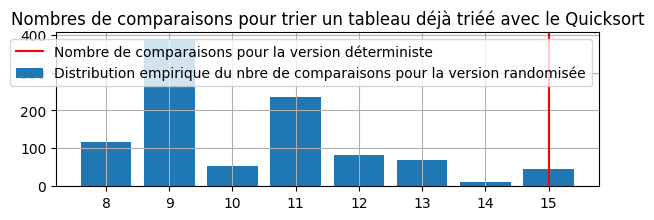

In [3]:
import numpy as np
import matplotlib.pyplot as plt

n = 1000 # Number of tests
comps_rand = np.array([randomized_quicksort(L_worst) for _ in range(n)])
ns, counts = np.unique(comps_rand, return_counts=True)

plt.figure(figsize=(7, 2))
plt.bar(ns, counts, label="Distribution empirique du nbre de comparaisons pour la version randomisée")
plt.axvline(x=comp_det, label="Nombre de comparaisons pour la version déterministe", c='red')
plt.title("Nombres de comparaisons pour trier un tableau déjà triéé avec le Quicksort")
plt.legend()
plt.grid(True)

**Commentaire** 

On constate que la version randomisée se comporte en général mieux face au pire des cas. Nous allons nous atarder dans la suite à justifier ce constat rigoureusement



### 2.3. Analyse de l'Espérance de Complexité

L'introduction de l'aléa dans le choix du pivot change la nature de l'analyse. La complexité $C(n)$ n'est plus une valeur fixe pour une entrée de taille $n$, but une **variable aléatoire**. Nous ne pouvons donc plus analyser $C(n)$ directement, mais nous pouvons analyser son **espérance** (sa moyenne), notée $E_n = \mathbb{E}[C_n]$.

Nous supposons que le pivot est choisi uniformément au hasard. Cela signifie que chaque élément de la liste a une probabilité $1/n$ d'être le $k$-ième plus petit élément (pour $k$ allant de $1$ à $n$).

1.  **Coût de Partition :** Quel que soit le pivot choisi, l'étape de partitionnement nécessite $n-1$ comparaisons (comme vu dans `randomized_quicksort`).
2.  **Sous-Problèmes :** Si le pivot choisi a le rang $k$ (c'est-à-dire qu'il est le $k$-ième plus petit élément), la partition créera deux sous-listes :
    * Une liste $L_<$ de taille $k-1$.
    * Une liste $L_>$ de taille $n-k$.
3.  **Récurrence :** En utilisant la linéarité de l'espérance, l'espérance totale $E_n$ est le coût de partitionnement (fixe) plus l'espérance des coûts des sous-problèmes, moyennée sur tous les choix possibles de $k$ :

    $$E_n = (n-1) + \sum_{k=1}^{n} \underbrace{P(\text{rang(pivot)}=k)}_{=1/n} \left( \mathbb{E}[C_{k-1}] + \mathbb{E}[C_{n-k}] \right)$$

    Ce qui donne la relation de récurrence fondamentale pour l'espérance :
    $$E_n = (n-1) + \frac{1}{n} \sum_{k=1}^{n} (E_{k-1} + E_{n-k})$$

    Nous utilisons les conditions de base $E_0 = 0$ et $E_1 = 0$, car une liste de 0 ou 1 élément ne nécessite aucune comparaison.

Pour résoudre cette récurrence, nous utilisons une astuce pour éliminer le terme de sommation :

1.  Multiplions l'équation (pour $n \ge 2$) par $n$ :
    $$(1) \quad n E_n = n(n-1) + 2 \sum_{j=0}^{n-1} E_j$$

2.  Écrivons la même équation pour $n-1$ (valable pour $n \ge 2$) :
    $$(2) \quad (n-1) E_{n-1} = (n-1)(n-2) + 2 \sum_{j=0}^{n-2} E_j$$

3.  Soustrayons (2) à (1) :
    $$n E_n - (n-1) E_{n-1} = [n(n-1) - (n-1)(n-2)] + 2 \left( \sum_{j=0}^{n-1} E_j - \sum_{j=0}^{n-2} E_j \right)$$

    En simplifiant les termes :
    $$n E_n - (n-1) E_{n-1} = (n-1)(n - (n-2)) + 2 E_{n-1}$$
    $$n E_n - (n-1) E_{n-1} = 2(n-1) + 2 E_{n-1}$$

4.  Réorganisons les termes pour isoler $n E_n$ :
    $$n E_n = (n-1) E_{n-1} + 2 E_{n-1} + 2(n-1)$$
    $$n E_n = (n+1) E_{n-1} + 2(n-1)$$

5.  Divisons l'ensemble par $n(n+1)$ pour faire apparaître un télescopage :
    $$\frac{E_n}{n+1} = \frac{E_{n-1}}{n} + \frac{2(n-1)}{n(n+1)}$$

6.  Posons $T_n = \frac{E_n}{n+1}$. La récurrence devient $T_n = T_{n-1} + \frac{2(n-1)}{n(n+1)}$.
    En déroulant cette somme (et en notant que $T_1 = E_1 / 2 = 0$) :
    $$T_n = \sum_{k=2}^{n} \frac{2(k-1)}{k(k+1)}$$

7.  Posons $T_n = \frac{E_n}{n+1}$. La récurrence est $T_n = T_{n-1} + \frac{2(n-1)}{n(n+1)}$ pour $n \ge 2$.
    Nous pouvons résoudre cette récurrence par télescopage, en partant de $T_1 = E_1 / 2 = 0$:
    $$T_n = \sum_{k=2}^{n} \frac{2(k-1)}{k(k+1)}$$

    En utilisant la décomposition en éléments simples $\frac{k-1}{k(k+1)} = \frac{2}{k+1} - \frac{1}{k}$:
    $$T_n = 2 \sum_{k=2}^{n} \left( \frac{2}{k+1} - \frac{1}{k} \right) = 4 \sum_{k=2}^{n} \frac{1}{k+1} - 2 \sum_{k=2}^{n} \frac{1}{k}$$

    Utilisons la $n$-ième série harmonique, $H_n = \sum_{k=1}^{n} \frac{1}{k}$.
    * $\sum_{k=2}^{n} \frac{1}{k} = H_n - 1$
    * $\sum_{k=2}^{n} \frac{1}{k+1} = \sum_{j=3}^{n+1} \frac{1}{j} = \left(H_{n+1} - 1 - \frac{1}{2}\right) = H_n + \frac{1}{n+1} - \frac{3}{2}$

    En substituant dans $T_n$ :
    $$T_n = 4 \left( H_n + \frac{1}{n+1} - \frac{3}{2} \right) - 2(H_n - 1)$$
    $$T_n = 4H_n + \frac{4}{n+1} - 6 - 2H_n + 2 = 2H_n + \frac{4}{n+1} - 4$$

8.  Maintenant, nous ré-substituons $E_n = (n+1)T_n$ pour trouver la solution **exacte** de l'espérance (pour $n \ge 1$, en vérifiant les cas $n=1, 2, 3$) :
    $$E_n = (n+1) \left( 2H_n + \frac{4}{n+1} - 4 \right) = 2(n+1)H_n + 4 - 4(n+1)$$
    $$E_n = 2(n+1)H_n - 4n$$

    Pour obtenir le comportement asymptotique, nous utilisons le développement de la série harmonique : $H_n = \ln(n) + \gamma + o(1)$, où $\gamma \approx 0.577$ (constante d'Euler-Mascheroni).

    $$E_n = 2(n+1)(\ln(n) + \gamma + o(1)) - 4n$$
    $$E_n = 2n\ln(n) + 2n\gamma + 2\ln(n) + 2\gamma + o(n) - 4n$$
    $$E_n = 2n\ln(n) + (2\gamma - 4)n + 2\ln(n) + 2\gamma + o(n)$$

    Comme $2\ln(n) + 2\gamma$ est un terme en $O(\ln n)$, il est $o(n)$ (négligeable devant $n$).
    $$E_n = 2n\ln(n) + (2\gamma - 4)n + o(n)$$

**Conclusion**

L'espérance de la complexité du Quicksort randomisé est $E_n = O(n \log n)$. L'analyse asymptotique précise donne $E_n \approx 2n\ln(n) + (2\gamma - 4)n$, où la constante $2\gamma - 4 \approx -2.8456$. L'introduction de l'aléa a réussi à éliminer la vulnérabilité au pire cas quadratique en garantissant (en moyenne) une performance asymptotiquement optimale.

Dans la suite, on confrontera les mesures expérimentales de la complexité de cette version randomisée du tri rapide, à ce résultat théorique que nous venons d'établir

### 2.5. Simulation et Analyse Empirique (Quicksort)

L'analyse théorique nous a donné le comportement asymptotique de l'espérance $E_n = 2n\ln(n) + (2\gamma - 4)n + o(n) \approx 2n\ln(n) -2.85n + o(n)$. Nous allons maintenant chercher à valider ce résultat empiriquement.

Une première approche consisterait à exécuter notre fonction `randomized_quicksort` (implémentée en 2.2) un grand nombre de fois sur des tableaux aléatoires de taille $n$, compter les comparaisons à chaque fois, et faire la moyenne. Cette approche, bien que valide, est coûteuse : elle implique de générer, manipuler et trier de grands tableaux, ce qui ajoute une surcharge de calcul (permutations, gestion de la mémoire) qui n'est pas l'objet de notre analyse (le nombre de comparaisons).

Une approche plus directe et efficace consiste à simuler non pas l'algorithme de tri lui-même, mais directement la **variable aléatoire** $C_n$ représentant le nombre de comparaisons.

Pour ce faire, nous utilisons la récurrence *distributionnelle* (en loi) de $C_n$. Soit $C_n$ le nombre de comparaisons pour trier $n$ éléments.
1.  Le premier appel effectue $n-1$ comparaisons pour partitionner.
2.  Le pivot est choisi uniformément au hasard. Son rang $U_n$ est donc une variable aléatoire uniforme sur $\{1, \dots, n\}$.
3.  Ce pivot génère deux sous-problèmes de tailles aléatoires $U_n - 1$ et $n - U_n$.
4.  Le coût total est la somme du coût de partitionnement et des coûts (indépendants) des appels récursifs sur les sous-problèmes.

On en déduit donc que le nombre aléatoire de comparaisons $C_n$ pour une liste de taille $n$ vérifie la relation en loi suivante :
\begin{align*}
C_0 &= 0, \\
C_1 &= 0, \\
\text{Pour } n \ge 2, \quad C_n &\stackrel{\text{(loi)}}{=} (n-1) + C'_{U_n-1} + C''_{n-U_n}
\end{align*}
où $U_n$ est une variable uniforme sur $\{1,\dots,n\}$, et $C'_k, C''_k$ sont des variables aléatoires indépendantes ayant la même loi que $C_k$, et indépendantes de $U_n$.

Le code suivant implémente une fonction `simulate_quicksort_complexity(n)` basée sur cette récurrence pour générer efficacement des échantillons de $C_n$.

In [4]:
def simulate_random_quicksort_complexity(n):
    """
    Simulates a single random execution of Quicksort and returns
    the number of comparisons C_n.
    Background noiseBackground noise
    This function is based on the distributional recurrence relation established upstream:
    
    Args:
        n (int): The size of the list.
        
    Returns:
        int: The (random) number of comparisons for this execution.
    """
    # Base cases
    if n <= 1:
        return 0

    pivot_rank = np.random.randint(1, n+1)
    comparisons = n - 1
    
    # Recursive calls
    comparisons += simulate_random_quicksort_complexity(pivot_rank - 1)
    comparisons += simulate_random_quicksort_complexity(n - pivot_rank)
    
    return comparisons

# --- Example of use ---
n_test = 100
# Run the simulation
comparisons = simulate_random_quicksort_complexity(n_test)
print(f"Simulation of C_n for n={n_test}: {comparisons} comparisons.")

n_test = 200
comparisons = simulate_random_quicksort_complexity(n_test)
print(f"Simulation of C_n for n={n_test}: {comparisons} comparisons.")

Simulation of C_n for n=100: 576 comparisons.
Simulation of C_n for n=200: 1773 comparisons.


**Test 1 : Simulation de la complexité $C_n$ de Quicksort Randomisé & Comparaison avec l'Espérance théorique $E_n$**

Nous allons maintenant confronter nos simulations de la variable aléatoire $C_n$ au résultat théorique de l'espérance $E_n \approx 2n\ln(n) -2.85n + o(n)$.

Le code suivant calcule $C_n$ (via `simulate_random_quicksort_complexity`) pour $n$ allant de 1 à N. Nous superposerons les points $(n, C_n)$ obtenus pour une exécution avec la courbe de l'espérance théorique $E(n) = 2n\ln(n) - 2.85n$.

De plus, pour visualiser l'ordre de grandeur de la dispersion (qui devrait être en $O(n)$ au vu du résultat théorique), nous tracerons une bande $E(n) \pm n$ pour observer la dispersion des simulations autour de la moyenne.

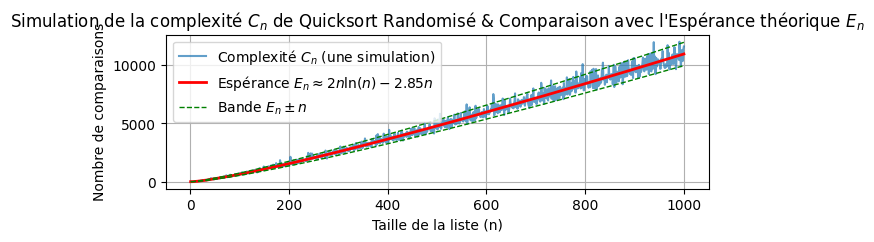

In [5]:
N = 1000
ns = np.arange(1, N + 1)

# Theoric mean E_n
E = lambda n: 2 * n * np.log(n) - 2.85 * n if n > 1 else 0 # Since we established the formula for n >= 2
# Vectorisation 
E_vec = np.vectorize(E)

Es = E_vec(ns)
Es_low = Es - ns
Es_high = Es + ns

# C_n
Cs = np.array([simulate_random_quicksort_complexity(n) for n in ns])

# Plotting
plt.figure(figsize=(7, 2))
plt.plot(ns, Cs, label="Complexité $C_n$ (une simulation)", alpha=0.7)
plt.plot(ns, Es, label=r"Espérance $E_n \approx 2n\ln(n) - 2.85n$", color='red', linewidth=2)
plt.plot(ns, Es_low, label=r"Bande $E_n \pm n$", color='green', linestyle='--', linewidth=1)
plt.plot(ns, Es_high, color='green', linestyle='--', linewidth=1)

plt.xlabel("Taille de la liste (n)")
plt.ylabel("Nombre de comparaisons")
plt.title("Simulation de la complexité $C_n$ de Quicksort Randomisé & Comparaison avec l'Espérance théorique $E_n$")
plt.legend()
plt.grid(True)

**Analyse & Commentaire**

Le graphique ci-dessus compare la simulation d'une unique trajectoire de la complexité aléatoire $C_n$ (en bleu) avec son espérance théorique $E_n$ (en rouge).

1.  **Validation de l'Espérance :** On observe que la courbe des simulations $C_n$ (bleu) oscille de manière très proche autour de la courbe de l'espérance théorique $E_n$ (rouge). Bien qu'il s'agisse d'une seule exécution aléatoire pour chaque $n$, la tendance centrale suit parfaitement la prédiction théorique en $O(n \log n)$.

2.  **Visualisation de la Dispersion :** L'écart entre la simulation et la moyenne, semble lui-même croître avec $n$. Les deux courbes en pointillés verts définissent un "cône" de largeur $2n$ centré sur la moyenne.

3.  **Ordre de Grandeur de l'Écart-Type :** La quasi-totalité de la trajectoire simulée reste confinée à l'intérieur de cette bande $E_n \pm n$. Cela suggère fortement que l'écart-type $\sigma_n$ est bien de l'ordre de $O(n)$, et donc que la variance $Var(C_n)$ est en $O(n^2)$.

**Test 2 : Visualisation de la distribution de $C_n$ pour n fixé**

Pour compléter l'analyse de la trajectoire, nous allons maintenant étudier la **distribution** de $C_n$ pour une taille $n$ fixée.

L'analyse précédente suggère que $C_n$ est une variable aléatoire fortement concentrée autour de son espérance $E_n$. Pour le vérifier, le code suivant effectue un grand nombre ($N$) de simulations de $C_n$ (pour $n$ fixé) et trace à la fois l'histogramme de la distribution empirique et son boxplot (autour de la moyenne cette fois).

Nous superposerons aux deux graphiques un trait indiquant la position de l'espérance théorique $E_n \approx 2n\ln(n) - 2.85n$.

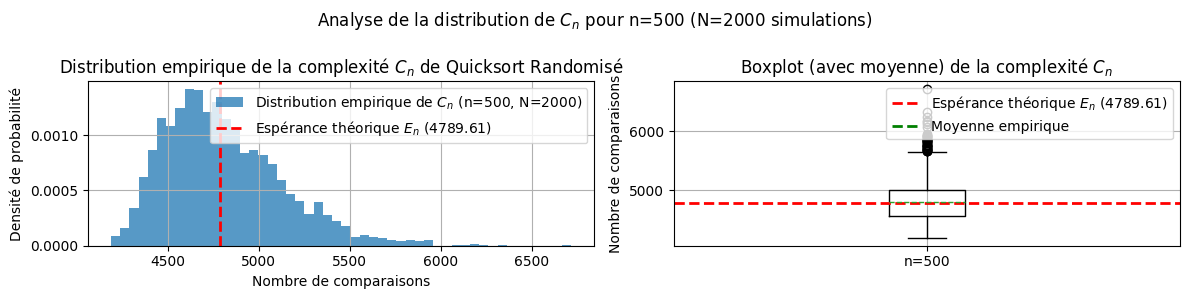

In [6]:
# Parameters for the simulation
n = 500 
N = 2000

E_n = E(n)
# Values of C_n
Cs = np.array([simulate_random_quicksort_complexity(n) for _ in range(N)])

# Plotting
plt.figure(figsize=(12, 3))
# Histogram
plt.subplot(1, 2, 1)
plt.hist(Cs, bins=50, density=True, label=f"Distribution empirique de $C_n$ (n={n}, N={N})", alpha=0.75)
plt.axvline(E_n, color='red', linestyle='--', linewidth=2, label=r"Espérance théorique $E_n$ " + f"({E_n:.2f})")
plt.xlabel("Nombre de comparaisons")
plt.ylabel("Densité de probabilité")
plt.title(f"Distribution empirique de la complexité $C_n$ de Quicksort Randomisé")
plt.legend()
plt.grid(True)

# Boxplot with mean not median
plt.subplot(1, 2, 2)
plt.boxplot(Cs, showmeans=True, meanline=True, medianprops={'visible': False}, tick_labels=[f"n={n}"])
plt.axhline(E_n, color='red', linestyle='--', linewidth=2, label=r"Espérance théorique $E_n$ " + f"({E_n:.2f})")
plt.plot([], [], color='green', linestyle='--', linewidth=2, label='Moyenne empirique')
plt.ylabel("Nombre de comparaisons")
plt.title(f"Boxplot (avec moyenne) de la complexité $C_n$")
plt.legend()
plt.grid(True)

plt.suptitle(f"Analyse de la distribution de $C_n$ pour n={n} (N={N} simulations)")
plt.tight_layout()

**Analyse & Commentaire**

L'histogramme (à gauche) et le boxplot (à droite) confirment et complètent visuellement les résultats de l'analyse théorique :

1.  **Validation de l'Espérance :** Le centre de la distribution empirique (le pic de l'histogramme) est quasi-aligné sur la ligne rouge, qui représente l'espérance théorique $E_n$. La moyenne empirique (ligne verte pointillée dans le boxplot) est également indiscernable de l'espérance théorique, validant expérimentalement la formule $E_n \approx 2n\ln(n) - 2.85n$.

2.  **Forme de la Distribution :** La distribution de $C_n$ est unimodale et globalement symétrique, s'approchant d'une distribution normale. Cela s'explique par le fait que $C_n$ est la somme d'un grand nombre de variables aléatoires (les coûts de partitionnement), évoquant le Théorème Central Limite (bien que la distribution limite exacte ne soit pas gaussienne).

3.  **Concentration et Dispersion :** La distribution est fortement "piquée" autour de sa moyenne, confirmant la concentration de $C_n$. Le boxplot révèle des *outliers* (les points au-delà des moustaches), indiquant une queue de distribution légèrement épaisse à droite. Ces points représentent les simulations "malchanceuses" où les choix de pivots ont été moins efficaces.

4.  **Ordre de Grandeur de l'Écart-Type :** Le boxplot montre que la majorité des simulations (la "boîte" interquartile) et même la quasi-totalité des données (les "moustaches") se situent dans une plage dont la largeur est visuellement cohérente avec l'ordre de grandeur de $n$ (ici $n=500$). Cela corrobore l'analyse précédente suggérant un écart-type $\sigma_n = O(n)$ et une variance $Var(C_n) = O(n^2)$.

**Conclusion** 

La simulation confirme non seulement la complexité moyenne en $O(n \log n)$, mais aussi la **forte concentration** de la variable aléatoire $C_n$ autour de sa moyenne. L'écart-type (en $O(n)$) est asymptotiquement négligeable devant l'espérance (en $O(n \log n)$), ce qui renforce l'idée que le comportement de Quicksort randomisé est très fiable et prévisible en pratique.

### 3. Vers une optimisation : Median-of-Three Quicksort

L'analyse précédente a établi que `randomized_quicksort` a une complexité attendue de $E_n \approx 2n\ln(n) - 2.85n$. Cette performance, bien qu'excellente, dépend toujours de la "qualité" du pivot choisi aléatoirement. Si, par malchance, le pivot est systématiquement choisi près des extrémités (le minimum ou le maximum), la performance se dégrade. La probabilité de choisir le pire pivot est de $2/n$, ce qui n'est pas négligeable pour les petits $n$.

Pour réduire la probabilité de choisir un mauvais pivot et ainsi diminuer la constante multiplicative **2** cachée dans le $O(2n \log n)$, une heuristique populaire est la stratégie **"Median-of-Three"** (Médiane de Trois).

L'idée est simple : au lieu de choisir un seul élément au hasard, on en choisit trois et on utilise leur médiane comme pivot. Il est intuitivement beaucoup moins probable que la médiane de trois éléments aléatoires soit un extrémum de la liste.

#### 3.1. Principe de la "Médiane de Trois"

**Principe :**

1.  **Cas de base :** Si $n \le 1$, renvoyer.
2.  **Diviser (Pivot & Partition) :**
    * Choisir trois indices distincts $i, j, k$ uniformément au hasard dans l'intervalle $[m, M-1]$.
    * Calculer la **médiane** de $\{arr[i], arr[j], arr[k]\}$. Soit $p_{idx}$ l'indice de cet élément médian.
    * Échanger `arr[m]` et `arr[p_idx]`. Le pivot $p$ est maintenant `arr[m]`.
    * Partitionner le reste du segment $[m+1, M-1]$ par rapport à $p$.
3.  **Régner & Combiner :**
    * Appeler récursivement l'algorithme sur les deux sous-segments.

**Discussion (Analyse des coûts et probabilités) :**

Cette stratégie modifie deux aspects du coût :

1.  **Coût du calcul du pivot ($\mathcal{M}$) :**
    Nous devons payer un coût supplémentaire pour trouver la médiane de $\{v_1, v_2, v_3\}$. En supposant les valeurs distinctes (ce qui est le cas avec probabilité 1 pour des lois continues) :
    * On compare $v_1$ et $v_2$ (1 comp).
    * On compare $v_3$ avec $\min(v_1, v_2)$ et $\max(v_1, v_2)$.
    * Si $v_3$ est un extremum ($v_3 < \min$ ou $v_3 > \max$), le coût total est de 2 comparaisons (proba 2/3).
    * Si $v_3$ est entre les deux ($\min < v_3 < \max$), une 3ème comparaison est nécessaire. Coût total = 3 comparaisons (proba 1/3).
    * L'espérance du coût du pivot est donc $\mathbb{E}[\mathcal{M}] = 2 \cdot (2/3) + 3 \cdot (1/3) = 7/3$.
    Le coût total de l'étape de partitionnement devient donc en moyenne $(n-3) + \mathbb{E}[\mathcal{M}] = n - 3 + 7/3 = n - 2/3$.

2.  **Qualité du pivot :**
    En contrepartie, la probabilité d'un partitionnement très déséquilibré est fortement réduite.
    * Dans `randomized_quicksort`, la probabilité de choisir le pire pivot (rang 1 ou rang $n$) est $P(\text{pire}) = 2/n$, ce qui est $O(1/n)$.
    * Avec la médiane de trois, notons $P_1, P_2, P_3$ les trois éléments choisis, de rangs $R_1, R_2, R_3$. Le pivot utilisé est $P_{med}$ (la médiane).
    * Pour que $P_{med}$ ait le rang 1, il faut qu'au moins deux des trois éléments choisis aient le rang 1. Soit $p = 1/n$ la probabilité de choisir l'élément de rang 1.
    * La probabilité que $k$ de ces éléments aient le rang 1 suit une loi binomiale $\mathcal{B}(3, p)$. La probabilité d'en avoir au moins deux est :
        $$P(\text{rang}(P_{med})=1) = P(k=2) + P(k=3) = \binom{3}{2} p^2(1-p) + \binom{3}{3} p^3$$
        $$P(\text{rang}(P_{med})=1) = 3p^2 - 3p^3 + p^3 = 3p^2 - 2p^3 = 3(1/n)^2 - 2(1/n)^3 = \frac{3n-2}{n^3}$$
    * Par symétrie, $P(\text{rang}(P_{med})=n)$ est identique. La probabilité totale de choisir le pire pivot est $P(\text{pire}) = 2 \times \frac{3n-2}{n^3} = \frac{6n-4}{n^3}$.

Nous avons donc réduit la probabilité d'un très mauvais pivot de $O(1/n)$ à $O(1/n^2)$, ce qui améliore la constante asymptotique de l'espérance $E_n$.

L'implémentation de cet algorithme n'est pas détaillée ici, car elle est structurellement identique à celle de `randomized_quicksort`. La seule modification réside dans le choix de l'indice `pivot_idx` avant l'étape de partitionnement, qui reste inchangée. Nous nous concentrerons donc sur la simulation de sa complexité.

In [7]:
def _get_median_of_three_pivot(arr, m, M):
    """
    Helper function to find the median of three random elements in arr[m:M].
    
    Returns the index of the median element and the number of comparisons
    used to find it (either 2 or 3).
    
    Args:
        arr (list): The list segment.
        m (int): The starting index.
        M (int): The ending index (exclusive).
        
    Returns:
        tuple (int, int): (index_of_median, comparison_cost)
    """
    # Note: We assume M - m >= 3, as n=2 is handled as a base case in the main function.
    indices = random.sample(range(m, M), 3)
    a, b, c = indices
    
    va, vb, vc = arr[a], arr[b], arr[c]

    # Perform comparisons to find the median
    if va < vb:
        if vb < vc: 
            comparisons = 2
            return b, comparisons
        elif va < vc: 
            comparisons = 3
            return c, comparisons
        else: 
            comparisons = 3
            return a, comparisons
    else: 
        if va < vc:
            comparisons = 2
            return a, comparisons
        elif vb < vc: 
            comparisons = 3
            return c, comparisons
        else: 
            comparisons = 3
            return b, comparisons

def median_of_three_quicksort(arr, m=0, M=None):
    """
    Sorts a list in-place (arr[m:M]) using Median-of-Three Quicksort.
    The pivot is the median of three randomly chosen elements.
    
    This function is instrumented to return the total number of comparisons.
    
    Args:
        arr (list): The list to be sorted.
        m (int): The starting index.
        M (int): The ending index (exclusive) of the subarray.
        
    Returns:
        int: The total number of comparisons performed.
    """
    if M is None:
        M = len(arr)

    n = M - m
    # Base cases
    if n <= 1:
        return 0
    if n == 2:
        # One comparison to sort two elements
        if arr[m] > arr[m+1]:
            arr[m], arr[m+1] = arr[m+1], arr[m]
        return 1
    
    # Pivot selection
    pivot_idx, comp_pivot = _get_median_of_three_pivot(arr, m, M)
    # Swap the chosen pivot with the first element (arr[m])
    arr[m], arr[pivot_idx] = arr[pivot_idx], arr[m]
    
    pivot = arr[m]
    pos = m  # 'pos' will be the final index of the pivot
    
    # Partitioning step
    comparisons = comp_pivot + (n - 1)
    
    for i in range(m + 1, M):
        if arr[i] < pivot:
            pos += 1
            arr[pos], arr[i] = arr[i], arr[pos]

    arr[pos], arr[m] = arr[m], arr[pos]
    
    # Recursive calls
    comparisons_left = median_of_three_quicksort(arr, m, pos)
    comparisons_right = median_of_three_quicksort(arr, pos + 1, M)
    
    return comparisons + comparisons_left + comparisons_right

In [8]:
# --- Example of use ---
n = 20 # Nber of elts
L = np.random.randint(0, 30, n).tolist()
print(f"Unsorted list: {L}")

# Test Median-of-Three
L_copy_med = list(L)
comps_med = median_of_three_quicksort(L_copy_med)
print(f"Sorted list (Median-of-Three): {L_copy_med}")
print(f"Comparisons made (Median-of-Three): {comps_med}")

# Test Standard Randomized for comparison
L_copy_rand = list(L)
comps_rand = randomized_quicksort(L_copy_rand)
print(f"\nSorted list (Randomized): {L_copy_rand}")
print(f"Comparisons made (Randomized): {comps_rand}")


L_worst = np.arange(0, n, 1).tolist()
print(f"\nWorst-case list for deterministic: {L_worst}")

# Test Median-of-Three on worst-case list
L_copy_worst_med = list(L_worst)
comps_worst_med = median_of_three_quicksort(L_copy_worst_med)
print(f"Sorted list (Median-of-Three): {L_copy_worst_med}")
print(f"Comparisons made (Median-of-Three): {comps_worst_med}")

# Test Standard Randomized on worst-case list
L_copy_worst_rand = list(L_worst)
comps_worst_rand = randomized_quicksort(L_copy_worst_rand)
print(f"Sorted list (Randomized): {L_copy_worst_rand}")
print(f"Comparisons made (Randomized): {comps_worst_rand}")

Unsorted list: [9, 13, 20, 24, 19, 4, 2, 18, 25, 1, 28, 19, 1, 27, 23, 22, 8, 26, 4, 21]
Sorted list (Median-of-Three): [1, 1, 2, 4, 4, 8, 9, 13, 18, 19, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
Comparisons made (Median-of-Three): 93

Sorted list (Randomized): [1, 1, 2, 4, 4, 8, 9, 13, 18, 19, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
Comparisons made (Randomized): 92

Worst-case list for deterministic: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Sorted list (Median-of-Three): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Comparisons made (Median-of-Three): 84
Sorted list (Randomized): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Comparisons made (Randomized): 62


### 3.1. Analyse de l'Espérance de Complexité

Soit $D_n$ la variable aléatoire du nombre de comparaisons pour `median_of_three_quicksort` sur une liste de taille $n$, et $E_n = \mathbb{E}[D_n]$ son espérance.

Nous adaptons l'analyse de la récurrence en loi :
1.  **Coût de Partition :** Pour $n \ge 3$, nous avons un coût fixe pour trouver le pivot, $\mathbb{E}[M] = 7/3$ (calculé dans le notebook initial), et un coût de $n-3$ pour partitionner les éléments restants (les 3 éléments du pivot ayant déjà été comparés entre eux).
2.  **Sous-Problèmes :** Soit $I$ le rang du pivot (la médiane des trois). Les sous-problèmes ont des tailles $I-1$ et $n-I$.

La récurrence en espérance pour $n \ge 3$ est donc :
$$E_n = \mathbb{E}[M] + (n-3) + \mathbb{E}[E_{I-1} + E_{n-I}]$$
$$E_n = \frac{7}{3} + (n-3) + \sum_{k=1}^{n} P(I=k) (E_{k-1} + E_{n-k})$$
$$E_n = n - \frac{2}{3} + \sum_{k=1}^{n} P(I=k) (E_{k-1} + E_{n-k})$$

Pour trouver $P(I=k)$, la probabilité que la médiane de trois éléments choisis au hasard ait le rang $k$, nous avons :
* Le nombre total de façons de choisir 3 indices distincts parmi $n$ est $\binom{n}{3}$.
* Pour que l'élément de rang $k$ soit la médiane, nous devons choisir un élément parmi les $k-1$ plus petits et un élément parmi les $n-k$ plus grands. Le nombre de choix favorables est $(k-1)(n-k)$.
* Cette probabilité est donc :
    $$P(I=k) = \frac{(k-1)(n-k)}{\binom{n}{3}} = \frac{6(k-1)(n-k)}{n(n-1)(n-2)}$$

**Remarque :** Cette probabilité est nulle pour $k=1$ et $k=n$, ce qui est correct.

En substituant, la récurrence complète pour $E_n$ (pour $n \ge 3$) devient :
$$E_n = n - \frac{2}{3} + \frac{6}{n(n-1)(n-2)} \sum_{k=2}^{n-1} (k-1)(n-k) (E_{k-1} + E_{n-k})$$

En utilisant la symétrie de la somme ($E_j$ et $E_{n-j-1}$), nous pouvons simplifier :
$$E_n = n - \frac{2}{3} + \frac{12}{n(n-1)(n-2)} \sum_{j=1}^{n-2} j(n-j-1) E_j$$

La résolution exacte de cette récurrence est très complexe. Nous allons utiliser une hypothèse sur la forme de la solution, pour trouver les coefficients dominants. Supposons, par analogie avec le Random Quicksort standard, que :
$$E_n = \alpha n \ln n + \beta n + o(n)$$

Pour $n$ grand, nous approximons le terme :
* $\frac{12}{n(n-1)(n-2)} = \frac{12}{n^3(1-3/n+O(n^{-2}))} = \frac{12}{n^3} (1 + O(n^{-1}))$

La récurrence devient asymptotiquement :
$$E_n = n + \left( \frac{12}{n^3} + O(n^{-4}) \right) \sum_{j=1}^{n-2} j(n-j-1) E_j + O(1)$$
<!-- $$E_n = n - \frac{2}{3} + \(\frac{12}{n^3} (1 + O(n^{-1}))\) \sum_{j=1}^{n-2} j(n-j-1) E_j$$ -->

Nous utilisons l'Ansatz (hypothèse sur la forme de la solution) :
$$E_j = \alpha j \ln j + \beta j + o(j)$$

Nous substituons l'Ansatz dans la somme $S = \sum_{j=1}^{n-2} j(n-j-1) E_j$.
$$S = \sum_{j=1}^{n-2} (nj - j^2 - j) (\alpha j \ln j + \beta j + o(j))$$

Nous séparons cette somme en trois parties :
$$S = \underbrace{\sum_{j=1}^{n-2} (nj - j^2) (\alpha j \ln j + \beta j)}_{S_g} - \underbrace{\sum_{j=1}^{n-2} j (\alpha j \ln j + \beta j)}_{S_{err1}} + \underbrace{\sum_{j=1}^{n-2} (nj - j^2 - j) o(j)}_{S_{err2}}$$

Nous utilisons la **Formule Sommatoire d'Euler-Maclaurin** [[1]](#ref1) (à l'ordre 0) pour approximer les sommes par des intégrales : $\sum_{j=a}^{b} f(j) = \int_a^b f(x) dx + O(f(a)) + O(f(b))$.

1.  **Analyse de $S_g$ :**
    Soit $f(j) = (nj - j^2)(\alpha j \ln j + \beta j)$. L'ordre de grandeur de l'intégrale est $\int_1^n O(n x^2 \ln x) dx = O(n^4 \ln n)$.
    Les termes de bord sont $f(1) = O(n)$ et $f(n-2) = O(n \cdot (n-2)^2 \ln(n-2)) = O(n^3 \ln n)$.
    L'erreur de l'approximation intégrale $S_g = \int_1^{n-2} f(x) dx + O(n^3 \ln n)$ est donc $O(n^3 \ln n)$.

2.  **Analyse de $S_{err1}$ :**
    Soit $h(j) = j (\alpha j \ln j + \beta j) = \alpha j^2 \ln j + \beta j^2$.
    L'intégrale est $\int_1^{n-2} h(x) dx = O(n^3 \ln n)$. L'erreur de bord $h(n-2)$ est $O(n^2 \ln n)$.
    Donc $S_{err1} = O(n^3 \ln n)$.

3.  **Analyse de $S_{err2}$ :**
    $S_{err2} = \sum_{j=1}^{n-2} O(nj) \cdot o(j) = o(n \sum j^2) = o(n \cdot n^3) = o(n^4)$.

En combinant les termes, $S = S_g - S_{err1} + S_{err2}$:
$$S = \left[ \int_1^n (nx - x^2)(\alpha x \ln x + \beta x) dx + O(n^3 \ln n) \right] - \left[ O(n^3 \ln n) \right] + \left[ o(n^4) \right]$$
Le terme dominant de l'intégrale est $O(n^4 \ln n)$. Le plus grand terme d'erreur est $O(n^3 \ln n)$, qui est absorbé par le $o(n^4)$ (car $\frac{n^3 \ln n}{n^4} \to 0$).

Cependant, pour l'identification, nous devons garder le terme d'erreur le plus significatif que nous avons *explicitement* séparé, qui est $S_{err1} = O(n^3 \ln n)$. Nous avons donc :
$$S = \sum_{j=1}^{n-2} (nj - j^2) (\alpha j \ln j + \beta j) + O(n^3 \ln n)$$
Le comportement dominant de la somme est donné par l'intégrale :
$$S = \int_{1}^{n} (nx - x^2) (\alpha x \ln x + \beta x) dx + O(n^3 \ln n)$$
$$S = \int_{1}^{n} (\alpha nx^2 \ln x + \beta nx^2 - \alpha x^3 \ln x - \beta x^3) dx + O(n^3 \ln n)$$

La somme $S$ est donc :
$$S = \frac{\alpha n^4}{12} \ln n + n^4 \left( \frac{\beta}{12} - \frac{7\alpha}{144} \right) + O(n^3 \ln n)$$

Nous réinjectons $S$ trouvé dans la récurrence $E_n = n + \left( \frac{12}{n^3} + O(n^{-4}) \right) S + O(1)$.

<!-- En utilisant le développement asymptotique de l'intégrale $S$:
$$S = \frac{\alpha n^4}{12} \ln n + n^4 \left( \frac{\beta}{12} - \frac{7\alpha}{144} \right) + O(n^3 \ln n)$$ -->

Nous substituons $S$ dans l'équation pour $E_n$ :
$$E_n = n + \left( \frac{12}{n^3} + O(n^{-4}) \right) \left[ \frac{\alpha n^4}{12} \ln n + n^4 \left( \frac{\beta}{12} - \frac{7\alpha}{144} \right) + O(n^3 \ln n) \right] + O(1)$$

Nous développons en ne gardant que les termes jusqu'à $O(n)$ :
$$E_n = n + \left( \frac{12}{n^3} \right) \left[ \frac{\alpha n^4}{12} \ln n + n^4 \left( \frac{\beta}{12} - \frac{7\alpha}{144} \right) \right] + \left( \frac{12}{n^3} \right) O(n^3 \ln n) + O(n^{-4}) O(n^4 \ln n) + O(1)$$
$$E_n = n + \alpha n \ln n + 12 n \left( \frac{\beta}{12} - \frac{7\alpha}{144} \right) + O(\ln n) + O(\ln n) + O(1)$$
$$E_n = \alpha n \ln n + n \left( 1 + \beta - \frac{7\alpha}{12} \right) + O(\ln n)$$

Nous identifions cette expression avec notre Ansatz $E_n = \alpha n \ln n + \beta n + o(n)$.
En notant que $O(\ln n)$ est bien $o(n)$, nous identifions les coefficients des termes dominants :

1.  **Termes en $O(n \ln n)$ :**
    $$\alpha n \ln n = \alpha n \ln n$$
    Cette équation est $0=0$. L'analyse est cohérente mais ne détermine pas $\alpha$.

2.  **Termes en $O(n)$ :**
    $$\beta n = n \left( 1 + \beta - \frac{7\alpha}{12} \right)$$
    $$\beta = 1 + \beta - \frac{7\alpha}{12}$$

De l'identification des termes en $O(n)$, le coefficient $\beta$ s'annule et nous obtenons une équation pour $\alpha$ :
$$0 = 1 - \frac{7\alpha}{12} \implies \alpha = \frac{12}{7}$$

Cette analyse par Ansatz nous a permis de déterminer le coefficient dominant $\alpha = \frac{12}{7}$. Elle échoue cependant à déterminer $\beta$, car ce terme s'annule.

Néamoins, une autre analyse complète donne le résultat asymptotique [[2]](#ref1):
$$\mathbb{E}[D_n] \approx \frac{12}{7} n\ln(n) - 1.827 n + o(n)$$

Le gain théorique est significatif : le facteur dominant est $\frac{12}{7} \approx 1.714$, ce qui est une amélioration d'environ $14\%$ par rapport au facteur $2$ du Quicksort randomisé standard.

Nous allons maintenant confronter ce résultat aux simulations empiriques.

---
**Références :**

<a id="ref1"></a>[1] Formule d'Euler-Maclaurin — Wikipédia.

<a id="ref2"></a>[2] Sedgewick, R., & Flajolet, P. (2013). *An introduction to the analysis of algorithms*. (Source du Th. 3.5 donnant le résultat asymptotique complet, y compris le terme $O(n)$).

### 3.2. Simulation et Analyse Empirique (Median-of-Three)

L'analyse théorique précédente (3.2) nous a donné le comportement asymptotique de l'espérance $E_n = \mathbb{E}[D_n] = \frac{12}{7}n\ln(n) - 1.827n + o(n)$. Nous allons maintenant chercher à valider ce résultat empiriquement.

Comme pour le Quicksort randomisé standard, simuler l'algorithme complet `median_of_three_quicksort` un grand nombre de fois serait coûteux. Une approche plus directe et efficace consiste à simuler non pas l'algorithme de tri lui-même, mais directement la **variable aléatoire** $D_n$ représentant le nombre de comparaisons.

Pour ce faire, nous utilisons la récurrence *distributionnelle* (en loi) de $D_n$. Soit $D_n$ le nombre de comparaisons pour trier $n$ éléments.

1.  **Cas de base :** $D_0=0$ et $D_1=0$. Pour $n=2$, une seule comparaison est nécessaire, donc $D_2=1$.
2.  **Cas $n \ge 3$ :**
    * L'algorithme calcule d'abord la médiane de trois éléments, ce qui a un coût aléatoire $M$ ($\mathbb{E}[M]=7/3$).
    * Il partitionne ensuite les $n-3$ éléments restants (coût $n-3$).
    * Il se rappelle récursivement sur deux sous-problèmes de tailles $I-1$ et $n-I$, où $I$ est le rang aléatoire du pivot.

On en déduit que le nombre aléatoire de comparaisons $D_n$ pour une liste de taille $n$ vérifie la relation en loi suivante :
\begin{align*}
D_0&=0,\\
D_1&=0,\\
D_2&=1,\\
\text{Pour }n\geq 3,\quad
D_n &\stackrel{\text{(loi)}}{=} M \;+\; (n-3) \;+\; D'_{I-1} \;+\; D''_{n-I},
\end{align*}
où :
* $M$ est une variable aléatoire (coût du pivot) valant 2 (proba 2/3) ou 3 (proba 1/3).
* $I$ est le rang aléatoire du pivot, avec la loi $P(I=k) = \frac{6(k-1)(n-k)}{n(n-1)(n-2)}$. (trouvé en amont)
* $D'_k, D''_k$ sont des variables aléatoires indépendantes ayant la même loi que $D_k$, et indépendantes de $(I,M)$.

Le code suivant implémente une fonction `simulate_median_of_three_complexity(n)` basée sur cette récurrence pour générer efficacement des échantillons de $D_n$.

In [9]:
# --- Helper Lambdas functions ---

# Returns the nber of comparisons to obtain the median of three elts
cost_M = lambda: 2 + (np.random.rand() < 2/3)

# Return the rank of the pivot in the case Median-of-Three Quicksort
rank_I = lambda n: np.sort(np.random.choice(np.arange(1, n + 1), size=3, replace=False))[1]

# --- Main Simulation Function ---
def simulate_median_of_three_complexity(n):
    """
    Simulates a single random execution of Median-of-Three Quicksort
    and returns the number of comparisons D_n.
    
    This function is based on the distributional recurrence relation established upstream.
    
    Args:
        n (int): The size of the list.
        
    Returns:
        int: The (random) number of comparisons for this execution.
    """
    # Base cases
    if n <= 1:
        return 0
    if n == 2:
        return 1 
    
    # Cost of finding the pivot (M)
    comparisons = cost_M()
    
    # Cost of partitioning the remaining n-3 elements
    comparisons += (n - 3)
    
    # Simulate the rank of the pivot (I)
    pivot_rank = rank_I(n)
    
    comparisons += simulate_median_of_three_complexity(pivot_rank - 1)
    comparisons += simulate_median_of_three_complexity(n - pivot_rank)
    
    return comparisons

# --- Example of use ---
n_test = 100
comparisons = simulate_median_of_three_complexity(n_test)
print(f"Simulation of D_n for n={n_test}: {comparisons} comparisons.")

n_test = 200
comparisons = simulate_median_of_three_complexity(n_test)
print(f"Simulation of D_n for n={n_test}: {comparisons} comparisons.")

Simulation of D_n for n=100: 529 comparisons.
Simulation of D_n for n=200: 1437 comparisons.


**Test 1 :** Simulation $D_n$ vs $C_n$ & Comparaison aux Espérances Théoriques

Nous allons maintenant confronter nos simulations de la variable aléatoire $D_n$ (Median-of-Three) au résultat théorique de l'espérance $E_D(n) \approx \frac{12}{7}n\ln(n) - 1.827n + o(n)$.

Pour évaluer le gain de cette optimisation, nous superposerons également les simulations de la complexité $C_n$ du Quicksort randomisé standard (calculé précédemment) et sa moyenne théorique $E_C(n) \approx 2n\ln(n) - 2.85n$.

De plus, pour visualiser l'ordre de grandeur de la dispersion de $D_n$, nous tracerons une bande $E_D(n) \pm n$.

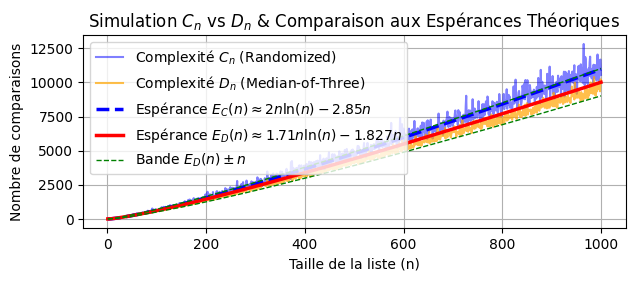

In [10]:
N = 1000
ns = np.arange(1, N + 1)

# E_n for Randomized Quicksort
E_C = lambda n: (2 * n * np.log(n) - 2.85 * n) if n > 1 else 0
E_C_vec = np.vectorize(E_C)
Es_C = E_C_vec(ns)

# E_n for Median-of-Three Quicksort
E_D = lambda n: ((12/7) * n * np.log(n) - 1.827 * n) if n > 1 else 0
E_D_vec = np.vectorize(E_D)
Es_D = E_D_vec(ns)

# Dispersion Bands (for D_n only)
Es_D_low = Es_D - ns
Es_D_high = Es_D + ns

# Simulations 
Cs = np.array([simulate_random_quicksort_complexity(n) for n in ns])
Ds = np.array([simulate_median_of_three_complexity(n) for n in ns])

# Plotting
plt.figure(figsize=(7, 2.5))
plt.plot(ns, Cs, label="Complexité $C_n$ (Randomized)", alpha=0.5, color='blue')
plt.plot(ns, Ds, label="Complexité $D_n$ (Median-of-Three)", alpha=0.7, color='orange')
plt.plot(ns, Es_C, label=r"Espérance $E_C(n) \approx 2n\ln(n) - 2.85n$", color='blue', linewidth=2.5, linestyle='--')
plt.plot(ns, Es_D, label=r"Espérance $E_D(n) \approx 1.71n\ln(n) - 1.827n$", color='red', linewidth=2.5, linestyle='-')
plt.plot(ns, Es_D_low, label=r"Bande $E_D(n) \pm n$", color='green', linestyle='--', linewidth=1)
plt.plot(ns, Es_D_high, color='green', linestyle='--', linewidth=1)

plt.xlabel("Taille de la liste (n)")
plt.ylabel("Nombre de comparaisons")
plt.title("Simulation $C_n$ vs $D_n$ & Comparaison aux Espérances Théoriques")
plt.legend()
plt.grid(True)

**Analyse & Commentaire**

Le graphique ci-dessus compare les simulations et les espérances théoriques du Quicksort randomisé standard ($C_n$, en bleu) et du Quicksort Median-of-Three ($D_n$, en orange).

1.  **Validation des Espérances :** On observe que les deux trajectoires simulées ($C_n$ et $D_n$) oscillent de manière très proche autour de leurs espérances théoriques respectives ($E_C(n)$ en bleu pointillé, $E_D(n)$ en rouge). Les tendances centrales suivent bien les prédictions théoriques en $O(n \log n)$.

2.  **Gain de l'Optimisation :** Le résultat le plus important est visible : la courbe orange ($D_n$) est systématiquement en dessous de la courbe bleue ($C_n$), et la moyenne théorique rouge ($E_D(n)$) est de même inférieure à la bleue ($E_C(n)$). Cela valide empiriquement que la stratégie "Median-of-Three" réduit significativement le nombre de comparaisons en moyenne (un gain d'environ $14\%$, comme l'indique le rapport des coefficients $\frac{12/7}{2} \approx 0.857$).

3.  **Dispersion de $D_n$ :** La trajectoire de $D_n$ reste, tout comme l'était celle de $C_n$, confinée à l'intérieur de la bande $E_D(n) \pm n$ (en vert). Cela suggère que la variance de $D_n$ est également en $O(n^2)$, et que son écart-type $\sigma_n = O(n)$. L'optimisation a donc réduit la moyenne sans dégrader la concentration de la mesure.

**Test 2 : Visualisation de la distribution de $D_n$ vs $C_n$ pour n fixé**

Pour compléter l'analyse de la trajectoire, nous allons maintenant étudier la **distribution** de $D_n$ pour une taille $n$ fixée, et la comparer directement à celle de $C_n$.

L'analyse précédente suggère que $D_n$ est, comme $C_n$, une variable aléatoire fortement concentrée autour de son espérance $E_D(n)$, mais avec une moyenne plus faible.

Pour le vérifier, le code suivant effectue un grand nombre ($N$) de simulations de $C_n$ et de $D_n$ (pour $n$ fixé) et trace les histogrammes des deux distributions empiriques obtenues, ainsi que leurs boxplots. Nous superposerons les traits verticaux indiquant les positions des deux espérances théoriques $E_C(n)$ et $E_D(n)$.

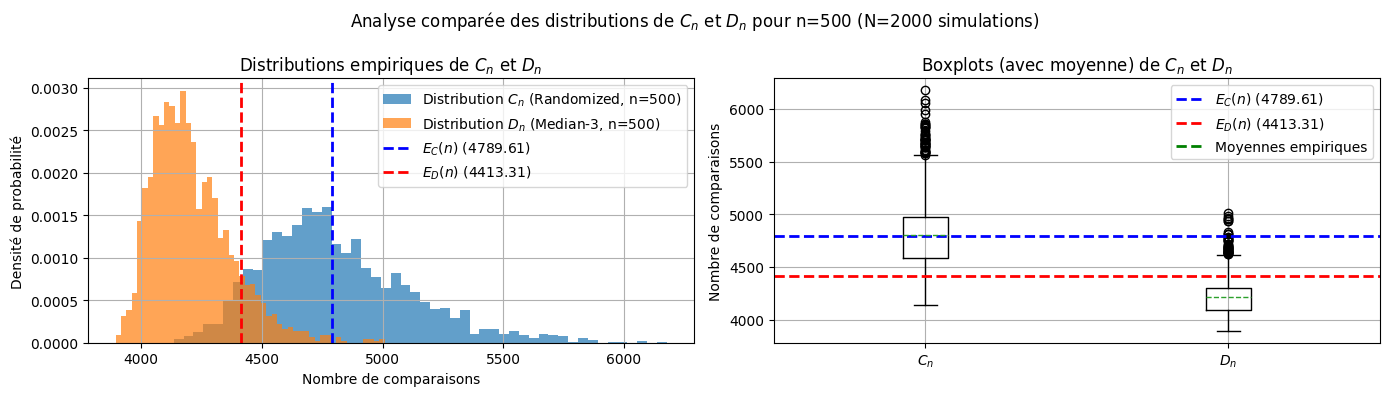

In [11]:
# Parameters for the simulation
n = 500 
N = 2000

# Theoretical Means
E_n_C = E_C(n)
E_n_D = E_D(n)

# Values of C_n and D_n
Cs = np.array([simulate_random_quicksort_complexity(n) for _ in range(N)])
Ds = np.array([simulate_median_of_three_complexity(n) for _ in range(N)])

# Plotting
plt.figure(figsize=(14, 4))

# Histogram
plt.subplot(1, 2, 1)
plt.hist(Cs, bins=50, density=True, label=f"Distribution $C_n$ (Randomized, n={n})", alpha=0.7)
plt.hist(Ds, bins=50, density=True, label=f"Distribution $D_n$ (Median-3, n={n})", alpha=0.7)

plt.axvline(E_n_C, color='blue', linestyle='--', linewidth=2, label=r"$E_C(n)$ " + f"({E_n_C:.2f})")
plt.axvline(E_n_D, color='red', linestyle='--', linewidth=2, label=r"$E_D(n)$ " + f"({E_n_D:.2f})")

plt.xlabel("Nombre de comparaisons")
plt.ylabel("Densité de probabilité")
plt.title("Distributions empiriques de $C_n$ et $D_n$")
plt.legend()
plt.grid(True)

# Boxplot with mean not median
plt.subplot(1, 2, 2)
# We plot them side-by-side
plt.boxplot([Cs, Ds], showmeans=True, meanline=True, medianprops={'visible': False}, tick_labels=[f"$C_n$", f"$D_n$"])
plt.axhline(E_n_C, color='blue', linestyle='--', linewidth=2, label=r"$E_C(n)$ " + f"({E_n_C:.2f})")
plt.axhline(E_n_D, color='red', linestyle='--', linewidth=2, label=r"$E_D(n)$ " + f"({E_n_D:.2f})")
# Dummy plot for empirical mean legend
plt.plot([], [], color='green', linestyle='--', linewidth=2, label='Moyennes empiriques')

plt.ylabel("Nombre de comparaisons")
plt.title("Boxplots (avec moyenne) de $C_n$ et $D_n$")
plt.legend()
plt.grid(True)

plt.suptitle(f"Analyse comparée des distributions de $C_n$ et $D_n$ pour n={n} (N={N} simulations)")
plt.tight_layout()

In [12]:
print("--- Comparaisons des moyennes théorique & empirique du cas Median-of-Three Quicksort")
print(f"Moyenne empirique de Dn (n={n}) :", np.mean(Ds))
print(f"Moyenne théorique de Dn (n={n}) : {E_n_D} +/- {n}")

--- Comparaisons des moyennes théorique & empirique du cas Median-of-Three Quicksort
Moyenne empirique de Dn (n=500) : 4209.5135
Moyenne théorique de Dn (n=500) : 4413.306941504736 +/- 500


**Analyse & Commentaire**

L'histogramme (à gauche) et le boxplot (à droite) permettent une comparaison visuelle directe des deux algorithmes pour $n=500$ :

1.  **Validation du Gain en Moyenne :**
    Le résultat le plus frappant est le décalage clair entre les 2 distributions. La distribution de $D_n$ (Median-of-Three, en orange) est nettement centrée à gauche de celle de $C_n$ (Randomized, en bleu). Les moyennes empiriques (lignes vertes pointillées) et les espérances théoriques (lignes pointillées colorées) confirment que $\mathbb{E}[D_n] < \mathbb{E}[C_n]$ en général. L'optimisation "Median-of-Three" est donc bien plus efficace en moyenne, réduisant le nombre de comparaisons.

2.  **Réduction de la Variance :**
    Le second gain est une **réduction de la dispersion**. L'histogramme de $D_n$ est visiblement plus étroit et plus piqué que celui de $C_n$. Le boxplot le confirme : la boîte interquartile (IQR) de $D_n$ est significativement plus petite, et ses moustaches sont plus courtes. Cela indique que $D_n$ a une variance plus faible que $C_n$. L'algorithme est donc non seulement plus rapide en moyenne, mais aussi plus prévisible.

3.  **Analyse de la Discrépance $E_D(n)$ vs $\bar{D}_n$ :**
    En observant attentivement le boxplot de $D_n$, on note un léger décalage : la moyenne empirique $\bar{D}_n$ (ligne verte) est légèrement **inférieure** à l'espérance théorique $E_D(n) \approx \frac{12}{7}n\ln(n) - 1.827n$ (ligne rouge) que nous avons tracée.
    Cet écart, bien que faible (et contenu dans la bande $E_D(n) \pm n$), n'est pas une erreur de simulation. Il s'explique par le fait que notre formule théorique est un **développement asymptotique** à deux termes ($O(n \ln n)$ et $O(n)$) qui omet tous les termes d'ordre inférieur, regroupés dans le $o(n)$ (comme les termes en $O(\ln n)$ et $O(1)$).
    Pour $n=500$, ces termes $o(n)$ ne sont pas encore négligeables et créent ce petit offset. Le résultat est donc **asymptotiquement correct** (l'écart $\bar{D}_n - E_D(n)$ est bien $o(n)$), mais analytiquement, il n'est pas encore parfaitement ajusté pour ce $n$.

Pour une analyse plus fine, on pourrait chercher à estimer un coefficient expérimental $\beta_{exp}$ qui capture mieux le comportement de l'algorithme pour des $n$ finis. On pourrait par exemple calculer $\beta_{exp}(n) = \frac{\bar{D}_n - \frac{12}{7}n\ln(n)}{n}$ et observer sa convergence vers la valeur théorique $\approx -1.827$ lorsque $n \to \infty$.

Nous allons maintenant nous attaquer à une application pratique et stimulante de la stratégie de partitionnement randomisé du Quicksort : le problème de la sélection (QuickSelect).

### 4. Application & Approfondissement : L'Algorithme de Sélection QuickSelect (QuickMedian)

Le principe de partitionnement aléatoire, si efficace pour le tri, peut être adapté pour résoudre un problème connexe mais plus simple : la **sélection**.

Le problème de la sélection consiste à trouver le $k$-ième plus petit élément d'une liste non triée. La solution naïve (trier la liste en $O(n \log n)$ et retourner `L[k-1]`) n'est pas optimale.

L'algorithme QuickSelect (parfois appelé QuickMedian pour le cas $k \approx n/2$) utilise le partitionnement pour atteindre une complexité linéaire moyenne.

#### 4.1. Analyse & Implémentation

**Principe**

L'idée est de s'inspirer de la stratégie Quicksort, mais de ne faire la récursion que sur la "bonne" moitié de la liste.

1.  **Cas de base :** Si le segment de liste `[m, M[` ne contient qu'un élément, c'est celui que l'on cherche.
2.  **Diviser (Pivot & Partition) :**
    * Choisir un pivot $p$ uniformément au hasard dans `arr[m:M[`.
    * Partitionner le segment `arr[m:M[` autour de $p$. Soit `pos` la position finale du pivot. Le coût est $n-1$ comparaisons (où $n = M-m$).
3.  **Régner (Décision & Récursion) :**
    * Calculer le nombre d'éléments $i$ dans le segment qui sont plus petits que le pivot ($i = pos - m$).
    * On cherche l'élément de rang $k$ (NB: on utilise ici $k$ comme un indice de 0 à $n-1$).
    * **Cas 1 (Trouvé) :** Si $i = k$, alors le pivot `arr[pos]` est le $k$-ième plus petit élément. L'algorithme s'arrête.
    * **Cas 2 (Gauche) :** Si $i > k$, l'élément est dans le sous-tableau de gauche. On cherche récursivement le $k$-ième élément dans `arr[m:pos[`.
    * **Cas 3 (Droite) :** Si $i < k$, l'élément est dans le sous-tableau de droite. On cherche récursivement l'élément de rang $(k - i - 1)$ dans `arr[pos+1:M[`.

La différence cruciale avec Quicksort est qu'au lieu de deux appels récursifs, QuickSelect n'en fait qu'**un seul**. L'algorithme ne trie que la partie de la liste qui contient l'élément recherché, éliminant l'autre moitié à chaque étape.

**Implémentation**

In [13]:
def quick_select(arr, k, m=0, M=None):
    """
    Finds the k-th smallest element in arr[m:M] (0-based index k)
    using the randomized QuickSelect algorithm. The array is modified in-place.
    
    This function is instrumented to return the k-th element and the
    total number of comparisons performed.
    
    Args:
        arr (list): The list to search in. (Will be modified in-place).
        k (int): The 0-based index of the element to find (e.g., k=0 for min).
        m (int): The starting index (inclusive) of the subarray.
        M (int): The ending index (exclusive) of the subarray.
        
    Returns:
        tuple (element, int): (k-th_smallest_element, total_comparisons)
    """
    if M is None:
        M = len(arr)
    
    n = M - m
    
    if n == 1:
        return arr[m], 0

    pivot_idx = random.randint(m, M - 1)
    arr[m], arr[pivot_idx] = arr[pivot_idx], arr[m]
    pivot = arr[m]
    pos = m
    
    # Partitioning 
    comparisons = n - 1
    for i in range(m + 1, M):
        if arr[i] < pivot:
            pos += 1
            arr[pos], arr[i] = arr[i], arr[pos]

    arr[pos], arr[m] = arr[m], arr[pos]

    i = pos - m 
    if i == k:
        return pivot, comparisons
    elif i > k:
        comps_recurse_tuple = quick_select(arr, k, m, pos)
        return comps_recurse_tuple[0], comparisons + comps_recurse_tuple[1]
    else: 
        comps_recurse_tuple = quick_select(arr, k - i - 1, pos + 1, M)
        return comps_recurse_tuple[0], comparisons + comps_recurse_tuple[1]

# --- Example of use ---
L = [4, 3, 5, 1, 6, 2, 8, 7]
print(f"Original list: {L}")
print(f"Correct sorted median: {np.median(L)}")

# Find the median 
k_median = (len(L) - 1) // 2
L_copy_med = list(L)
element_med, comps_med = quick_select(L_copy_med, k_median)
print(f"\nMedian (k={k_median}): {element_med}")
print(f"Comparisons made: {comps_med}")
print(f"Partially sorted list: {L_copy_med}") 

Original list: [4, 3, 5, 1, 6, 2, 8, 7]
Correct sorted median: 4.5

Median (k=3): 4
Comparisons made: 7
Partially sorted list: [2, 3, 1, 4, 6, 5, 8, 7]


#### 4.2. Analyse de l'Espérance de Complexité

Soit $S_{n,k}$ le nombre de comparaisons pour trouver le $k$-ième élément (1-based) dans une liste de $n$ éléments, et $E_n(k) = \mathbb{E}[S_{n,k}]$ son espérance.

Lors d'un appel, l'algorithme effectue $n-1$ comparaisons pour la partition. Le pivot choisi a un rang $U_n$ (uniforme sur $\{1, \dots, n\}$) qui détermine la taille des sous-problèmes $U_n-1$ et $n-U_n$. L'algorithme ne récurse que sur l'un des deux.

La récurrence exacte pour l'espérance est :
$$E_n(k) = (n-1) + \sum_{i=1}^{n} P(U_n=i) \cdot \mathbb{E}[\text{coût récursif} \mid U_n=i]$$
$$E_n(k) = (n-1) + \frac{1}{n} \left( \sum_{i=1}^{k-1} E_{n-i}(k-i) + \sum_{i=k+1}^{n} E_{i-1}(k) \right)$$

##### **Analyse Asymptotique Exacte (Variables Indicatrices)**

Nous cherchons maintenant une formule asymptotique exacte pour $n$ et $k$ donnés. Cette analyse, basée sur la méthode des variables indicatrices [[1]](#ref1), est plus complexe mais permet d'obtenir la forme exacte.

**La Méthode : Variables Indicatrices** [[1]](#ref1)

Soit $Z = \{Z_1, \dots, Z_n\}$ l'ensemble trié des éléments.
Soit $X_{ij}$ la variable indicatrice de l'événement "$Z_i$ est comparé à $Z_j$".

L'espérance du nombre total de comparaisons est la somme des probabilités de chaque comparaison :
$$E_n(k) = \sum_{1 \le i < j \le n} P(X_{ij}=1)$$

**La Condition de Comparaison**

Dans QuickSelect, la logique d'analyse est la suivante :
Nous cherchons à trouver $Z_k$. L'algorithme partitionne autour d'un pivot $p$ et, de manière cruciale, **élimine** le sous-problème qui ne contient pas $Z_k$.

$Z_i$ et $Z_j$ (supposons $i < j$) ne seront **pas** comparés dans deux cas :
1.  **Échec par Séparation** : Un pivot $p$ est choisi *entre* eux ($Z_i < p < Z_j$). Ils sont séparés dans deux sous-problèmes et ne se rencontreront jamais.
2.  **Échec par Élimination** : Un pivot $p$ est choisi tel que $Z_i$ et $Z_j$ sont d'un côté, mais $Z_k$ est de l'autre. L'algorithme suit $Z_k$ et **jette** le sous-problème contenant $Z_i$ et $Z_j$ avant qu'ils aient pu être comparés.

Le sort de la paire $(Z_i, Z_j)$ est donc scellé par le **premier pivot $p$ qui est choisi dans l'intervalle minimal contenant $Z_i$, $Z_j$ et $Z_k$**. Appelons cet intervalle l'Ensemble Critique $C$.

* Si ce premier pivot $p$ est $Z_i$ ou $Z_j$ $\implies$ **Comparaison !**
* Si ce premier pivot $p$ est n'importe quel *autre* élément de $C$ $\implies$ **Pas de comparaison** (soit par Séparation, soit par Élimination).

Par conséquent, $Z_i$ et $Z_j$ sont comparés si et seulement si $Z_i$ ou $Z_j$ est le premier pivot choisi dans cet **intervalle minimal contenant $Z_i$, $Z_j$ et $Z_k$**.

La taille de cet intervalle est $\max(j-i+1, j-k+1, k-i+1)$.
Puisque $Z_i$ et $Z_j$ sont les deux seuls "bons" pivots (gagnants) parmi cet ensemble, la probabilité de comparaison est [[1]](#ref1), [[2]](#ref2) :
$$P(X_{ij}=1) = \frac{2}{\max(j-i+1, j-k+1, k-i+1)}$$

**Analyse Géométrique de la Somme**

L'espérance $E_n(k)$ est donc la somme de ces probabilités sur tous les $1 \le i < j \le n$.

Pour calculer cette somme double complexe, l'analyse [[2]](#ref2) décompose le plan $(i, j)$ en plusieurs régions, comme illustré sur le schéma ci-dessous (ici pour $k < n/2$).

<img src="figures/schema_quick_select_complexity.png" style="width:300px;"/>

*Schéma de l'analyse géométrique pour $E_n(k)$ (inspiré de [[2]](#ref2)).*

En utilisant le développement asymptotique du nombre harmonique, qui implique $H_n = \ln n + \gamma + o(1)$, une conséquence directe est que la différence $H_b - H_a = \ln(b/a) + o(1)$ pour $a, b \to \infty$. Nous utilisons cette propriété pour évaluer rigoureusement les contributions.

1.  **Région 1 ($i < j < k$)**
    * **Analyse :** $P(X_{ij}=1) = \frac{2}{k-i+1}$. La somme est $E_1 = \sum_{i=0}^{k-2} \sum_{j=i+1}^{k-1} \frac{2}{k-i+1}$.
    * **Évaluation :** La somme interne sur $j$ vaut $(k-i-1)$.
        $$E_1 = 2 \sum_{q=3}^{k+1} \frac{q-2}{q} = 2 \left[ \sum_{q=3}^{k+1} 1 - 2 \sum_{q=3}^{k+1} \frac{1}{q} \right]$$
        $$E_1 = 2 \left[ (k-1) - 2(H_{k+1} - H_2) \right]$$
    * **Contribution :** $E_1 = 2k - 4 H_k + O(1) = 2k - 4 \ln k + O(1) = 2k + O(\ln k)$.

2.  **Région 2 ($k < i < j$)**
    * **Analyse :** $P(X_{ij}=1) = \frac{2}{j-k+1}$. La somme est $E_2 = \sum_{j=k+2}^{n-1} \sum_{i=k+1}^{j-1} \frac{2}{j-k+1}$.
    * **Évaluation :** La somme interne sur $i$ vaut $(j-k-1)$.
        $$E_2 = 2 \sum_{q=3}^{n-k} \frac{q-2}{q} = 2 \left[ (n-k-2) - 2(H_{n-k} - H_2) \right]$$
    * **Contribution :** $E_2 = 2(n-k) - 4 H_{n-k} + O(1) = 2(n-k) - 4 \ln(n-k) + O(1) = 2(n-k) + O(\ln n)$.

3.  **Région 3 ($i < k < j$, triangle "vert citron")**
    * **Analyse :** $P(X_{ij}=1) = \frac{2}{j-i+1}$. Somme sur les diagonales $q = j-i$, de $q=2$ à $k$. Longueur de la $q$-ième diagonale : $(q-1)$.
    * **Somme :** $E_3 = \sum_{q=2}^{k} (q-1) \cdot \frac{2}{q}$.
    * **Évaluation :**
        $$E_3 = 2 \sum_{q=2}^{k} \left(1 - \frac{1}{q}\right) = 2 \left[ (k-1) - (H_k - 1) \right] = 2(k - H_k)$$
    * **Contribution :** $E_3 = 2k - 2\ln k + O(1) = 2k + O(\ln k)$.

4.  **Région 4 ($i < k < j$, parallélogramme "violet")**
    * **Analyse :** Somme modélisée par $k$ termes (hauteur) pour chaque "tranche" $q \in [k+1, n-k]$, avec $P = 2/q$.
    * **Somme :** $E_4 = \sum_{q=k+1}^{n-k} k \cdot \frac{2}{q}$.
    * **Évaluation :**
        $$E_4 = 2k \sum_{q=k+1}^{n-k} \frac{1}{q} = 2k (H_{n-k} - H_k)$$
        $$E_4 = 2k [ (\ln(n-k) + \gamma + o(1)) - (\ln k + \gamma + o(1)) ]$$
    * **Contribution :** $E_4 = 2k(\ln(n-k) - \ln k) + k \cdot o(1) = 2k \ln\left(\frac{n-k}{k}\right) + o(k)$.

5.  **Région 5 ($i < k < j$, triangle "bleu ciel")**
    * **Analyse :** Somme sur les diagonales $q = j-i$ de $q=n-k+1$ à $n-1$. Longueur de la $q$-ième diagonale : $(n-q)$. Probabilité : $2/q$.
    * **Somme :** $E_5 = \sum_{q=n-k+1}^{n-1} (n-q) \cdot \frac{2}{q}$.
    * **Évaluation :**
        $$E_5 = 2 \sum_{q=n-k+1}^{n-1} \left(\frac{n}{q} - 1\right) = 2 \left[ n \sum_{q=n-k+1}^{n-1} \frac{1}{q} - \sum_{q=n-k+1}^{n-1} 1 \right]$$
        $$E_5 = 2 \left[ n (H_{n-1} - H_{n-k}) - (k-1) \right]$$
        $$E_5 = 2 [ n (\ln(n-1) - \ln(n-k) + o(1)) - k + 1 ]$$
    * **Contribution :** $E_5 = 2n \ln\left(\frac{n}{n-k}\right) - 2k + n \cdot o(1) + O(1) = 2(n \ln n - n \ln(n-k) - k) + o(n)$.

---

**Somme Totale**

En additionnant les contributions ($E_n(k) = E_1 + E_2 + E_3 + E_4 + E_5$), les termes $o(k)$, $O(\ln k)$, $O(\ln n)$ et $O(1)$ sont absorbés par le $o(n)$ global.

$$E_n(k) = (2k) + (2n-2k) + (2k) + \left[ 2k \ln\left(\frac{n-k}{k}\right) \right] + \left[ 2n \ln\left(\frac{n}{n-k}\right) - 2k \right] + o(n)$$

Les termes linéaires se simplifient : $2k + 2n - 2k + 2k - 2k = 2n$.

$$E_n(k) = 2n + 2k \ln\left(\frac{n-k}{k}\right) + 2n \ln\left(\frac{n}{n-k}\right) + o(n)$$

En factorisant les termes en $n$ [[2]](#ref2) :

$$E_n(k) = 2n\left(1+\ln\frac{n}{n-k}\right) + 2k\ln\frac{n-k}{k} + o(n)$$

Ce qui est équivalent à la forme (en supposant que $k = \Theta (n)$) :

$$E_n(k) = \left( 2n\left(1+\ln\frac{n}{n-k}\right) + 2k\ln\frac{n-k}{k} \right) (1+o(1))$$

---

**Conclusion : Le Cas de la Médiane**

Nous avons maintenant une formule asymptotique pour tout $k$. L'espérance de la complexité de QuickSelect est bien $O(n)$ pour n'importe quel $k$.

Pour le cas spécifique de la médiane ($k=n/2$, vérifiant bien $k = \Theta (n)$), on substitue $k=n/2$ dans la formule [[2]](#ref2) :

$$E_n(n/2) = \left( 2n\left(1+\ln\frac{n}{n-n/2}\right) + 2\frac{n}{2}\ln\frac{n-n/2}{n/2} \right) (1+o(1))$$

$$E_n(n/2) = \left( 2n\left(1+\ln\frac{n}{n/2}\right) + n\ln\frac{n/2}{n/2} \right) (1+o(1))$$

$$E_n(n/2) = \left( 2n(1+\ln 2) + n\ln(1) \right) (1+o(1))$$

$$E_n(n/2) = 2n(1 + \ln 2) + o(n)$$

L'analyse asymptotique précise est donc :
$$E_n(n/2) = 2(1 + \ln 2)n + o(n) \approx 3.386 n + o(n)$$

Nous allons maintenant simuler la variable aléatoire $S_{n,k}$ (nombre de comparaisons) pour vérifier empiriquement ce comportement linéaire et cette constante théorique dans le cas $k=\frac{n}{2}$.

---
**Références :**

<a id="ref1"></a>[1] Mitzenmacher, M., & Upfal, E. (2005). *Probability and Computing*. Cambridge University Press. (Pour la méthode des variables indicatrices $X_{ij}$ et la condition de comparaison).

<a id="ref2"></a>[2] *Blum-style analysis of randomized select*. (2007). Blog post. (Pour la dérivation de $P(X_{ij}=1)$ dans le cas de la sélection, l'analyse géométrique et la formule asymptotique $E_n(k)$).

### 4.3. Simulation et Analyse Empirique (QuickSelect)

L'analyse théorique précédente (4.2) a établi que la complexité en espérance de QuickSelect est $E_n(k) = O(n)$, et a fourni une formule asymptotique exacte pour $E_n(k)$ en fonction de $n$ et $k$ :
$$E_n(k) = 2n\left(1+\ln\frac{n}{n-k}\right) + 2k\ln\frac{n-k}{k} + o(n)$$

Pour le cas spécifique de la médiane ($k=n/2$), cela se simplifie en $E_n(n/2) = 2(1 + \ln 2)n + o(n) \approx 3.386 n + o(n)$.

Nous allons maintenant chercher à valider ces deux résultats empiriquement. L'objectif est double :
1.  Valider la constante $3.386$ pour le cas de la médiane ($k=n/2$).
2.  Valider la formule générale $E_n(k)$ en faisant varier le rang $k$ pour un $n$ fixé.

Tout comme pour Quicksort, simuler l'algorithme complet `quick_select` serait coûteux. Nous allons donc simuler directement la variable aléatoire $S_{n,k}$ (nombre de comparaisons) en utilisant sa récurrence distributionnelle.

On en déduit que le nombre aléatoire de comparaisons $S_{n,k}$ pour `QuickSelect` vérifie :
\begin{align*}
S_{n,k} &= 0, && \text{si } n \le 1,\\
\text{Pour tout } n \ge 2,\quad
S_{n,k} &\stackrel{\text{(loi)}}{=} (n-1) \;+\;
\begin{cases}
S'_{U-1,k} & \text{si } U > k,\\
S''_{n-U,k-U} & \text{si } U < k,\\
0, & \text{si } U = k,
\end{cases}
\end{align*}
où $U$ (que nous nommerons `pivot_rank`) est une variable uniforme sur $\{1,\dots,n\}$ représentant le rang du pivot choisi, et $S'_{n,k}, S''_{n,k}$ sont des variables aléatoires indépendantes de même loi que $S_{n,k}$ et indépendantes de $U$.

Le code suivant implémente une fonction `simulate_quick_select_complexity(n, k)` basée sur cette récurrence pour générer efficacement des échantillons de $S_{n,k}$.

In [14]:
def simulate_quick_select_complexity(n, k):
    """
    Simulates a single random execution of QuickSelect(n, k) and returns
    the number of comparisons S_{n,k}.
    
    This function is based on the distributional recurrence relation established upstream.
    Note: k is 1-based (rank 1 to n).
    
    Args:
        n (int): The size of the list.
        k (int): The 1-based rank of the element to find (1 <= k <= n).
        
    Returns:
        int: The (random) number of comparisons for this execution.
    """
    if n <= 1:
        return 0
    
    comparisons = n - 1
    pivot_rank = np.random.randint(1, n + 1)
    if pivot_rank == k:
        return comparisons
    elif pivot_rank > k:
        comparisons += simulate_quick_select_complexity(pivot_rank - 1, k)
    else: 
        comparisons += simulate_quick_select_complexity(n - pivot_rank, k - pivot_rank)
        
    return comparisons

# --- Example of use ---
n_test = 100
k_test = 100 // 1
comparisons = simulate_quick_select_complexity(n_test, k_test)
print(f"Simulation of S_n,k for (n={n_test}, k={k_test}): {comparisons} comparisons.")

Simulation of S_n,k for (n=100, k=100): 179 comparisons.


**Test 1 : Simulation de la trajectoire $S_{n,k}$ et comparaison avec l'Espérance $E_n(k)$**

Nous allons maintenant confronter nos simulations de la variable aléatoire $S_{n,k}$ (QuickSelect) au résultat théorique de l'espérance $E_n(k)$ établi en 4.2 :
$$E_n(k) = 2n\left(1+\ln\frac{n}{n-k}\right) + 2k\ln\frac{n-k}{k} + o(n)$$
Et en particulier, le cas de la médiane : $E_n(n/2) = 2(1 + \ln 2)n + o(n) \approx 3.386 n + o(n)$.

Le code suivant calcule $S_{n,k}$ (via `simulate_quick_select_complexity`) pour $n$ allant de 1 à N, et ce pour trois régimes de $k$ (médiane $k \approx n/2$, premier quartile $k \approx n/4$, et troisième quartile $k \approx 3n/4$).

Nous superposerons les points $(n, S_{n,k})$ obtenus pour une exécution avec la courbe de l'espérance théorique correspondante $E_n(k)$. De plus, nous tracerons la bande $E_n(k) \pm n$ pour observer la dispersion des simulations.

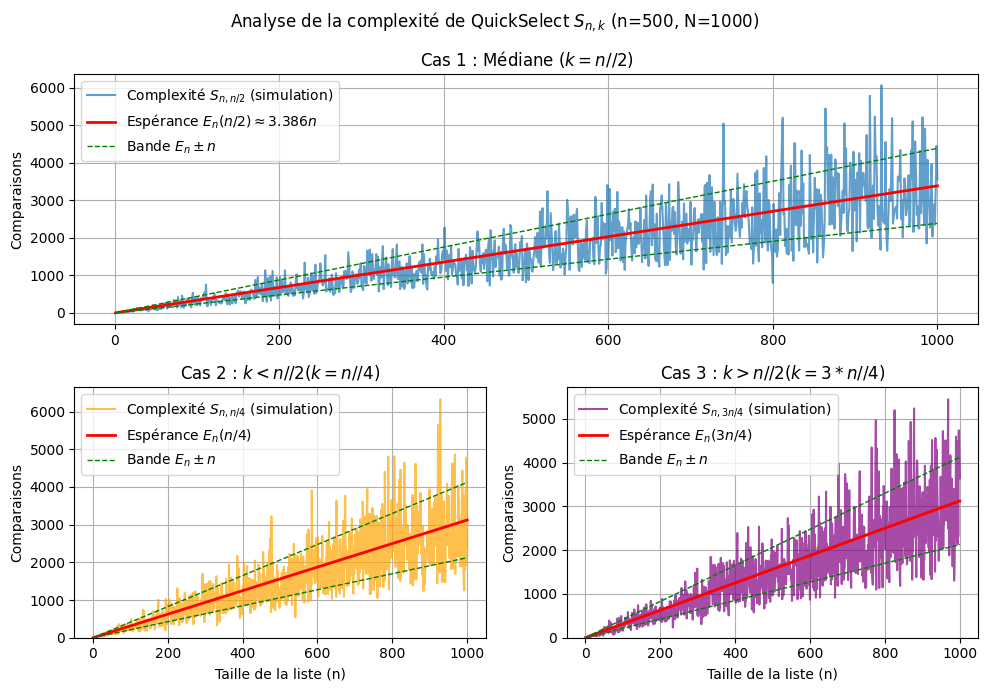

In [18]:
N = 1000
ns = np.arange(1, N + 1)

def E_nk(n, k):
    # Handle base/edge cases
    if n <= 1 or k < 0 or k >= n:
        return 0
    
    if k == 0:
        # More precise (from Knuth): 2n - 2*H_n + 2
        return 2*n - 2*(np.log(n) + 0.577) + 2

    term1 = 2 * n * (1 + np.log(n / (n - k)))
    term2 = 2 * k * np.log((n - k) / k)
    return term1 + term2

# Vectorization
E_nk_vec = np.vectorize(E_nk)


# Plotting 
fig = plt.figure(figsize=(10, 7))

# Plot 1: Median (k = (n-1)//2)
ax_top = plt.subplot(2, 1, 1)

k_med = lambda n: n // 2
ks_med = k_med(ns)

Es_med = E_nk_vec(ns, ks_med)
Es_med_low = Es_med - ns
Es_med_high = Es_med + ns

# Simulate S_nk
Ss_med = np.array([simulate_quick_select_complexity(n, k) for n, k in zip(ns, ks_med)])

ax_top.plot(ns, Ss_med, label="Complexité $S_{n, n/2}$ (simulation)", alpha=0.7)
ax_top.plot(ns, Es_med, label=r"Espérance $E_n(n/2) \approx 3.386n$", color='red', linewidth=2)
ax_top.plot(ns, Es_med_low, label=r"Bande $E_n \pm n$", color='green', linestyle='--', linewidth=1)
ax_top.plot(ns, Es_med_high, color='green', linestyle='--', linewidth=1)
ax_top.set_ylabel("Comparaisons")
ax_top.set_title(r"Cas 1 : Médiane ($k = n//2$)")
ax_top.legend()
ax_top.grid(True)

# Plot 2: k < n // 2 
ax_down_left = plt.subplot(2, 2, 3)

k_left = lambda n: n // 4
ks_left = k_left(ns)

Es_left = E_nk_vec(ns, ks_left)
Es_left_low = Es_left - ns
Es_left_high = Es_left + ns

Ss_left = np.array([simulate_quick_select_complexity(n, k) for n, k in zip(ns, ks_left)])

ax_down_left.plot(ns, Ss_left, label="Complexité $S_{n, n/4}$ (simulation)", alpha=0.7, color='orange')
ax_down_left.plot(ns, Es_left, label=r"Espérance $E_n(n/4)$", color='red', linewidth=2)
ax_down_left.plot(ns, Es_left_low, label=r"Bande $E_n \pm n$", color='green', linestyle='--', linewidth=1)
ax_down_left.plot(ns, Es_left_high, color='green', linestyle='--', linewidth=1)
ax_down_left.set_xlabel("Taille de la liste (n)")
ax_down_left.set_ylabel("Comparaisons")
ax_down_left.set_title(r"Cas 2 : $k < n // 2 (k = n//4)$")
ax_down_left.legend()
ax_down_left.grid(True)
ax_down_left.set_ylim(bottom=0)

# Plot 3: k > n // 2
ax_down_right = plt.subplot(2, 2, 4)

k_right = lambda n: 3 * k_left(n)
ks_right = k_right(ns)

Es_right = E_nk_vec(ns, ks_right)
Es_right_low = Es_right - ns
Es_right_high = Es_right + ns

Ss_right = [simulate_quick_select_complexity(n, k_rank) for n, k_rank in zip(ns, ks_right)]

ax_down_right.plot(ns, Ss_right, label="Complexité $S_{n, 3n/4}$ (simulation)", alpha=0.7, color='purple')
ax_down_right.plot(ns, Es_right, label=r"Espérance $E_n(3n/4)$", color='red', linewidth=2)
ax_down_right.plot(ns, Es_right_low, label=r"Bande $E_n \pm n$", color='green', linestyle='--', linewidth=1)
ax_down_right.plot(ns, Es_right_high, color='green', linestyle='--', linewidth=1)
ax_down_right.set_xlabel("Taille de la liste (n)")
ax_down_right.set_ylabel("Comparaisons")
ax_down_right.set_title(r"Cas 3 : $k > n // 2 (k = 3 * n // 4)$")
ax_down_right.legend()
ax_down_right.grid(True)
ax_down_right.set_ylim(bottom=0)

plt.suptitle(r"Analyse de la complexité de QuickSelect $S_{n,k}$" + f" (n={n}, N={N})")
plt.tight_layout()

**Analyse & Commentaire**

Les trois graphiques confirment de manière éclatante l'analyse théorique de la complexité $O(n)$ de QuickSelect.

1.  **Validation de la Linéarité :** Sur les trois graphiques, la trajectoire de la simulation (bleu, orange, violet) suit parfaitement la tendance linéaire de l'espérance théorique (rouge).

2.  **Validation de la Formule $E_n(k)$ :**
    * **Cas 1 (Médiane) :** Le graphique du haut montre une excellente adéquation entre la simulation et la formule $E_n(n/2) \approx 3.386n$.
    * **Cas 2 & 3 (Quartiles) :** Les deux graphiques du bas ($k \approx n/4$ et $k \approx 3n/4$) sont statistiquement très similaires, ce qui valide la symétrie de la formule asymptotique ($E_n(k) = E_n(n-k)$). Ils sont valides avec notre formule générale $E_n(k)$ et ils convergent tous deux vers une constante inférieure à celle de la médiane ($E_n(n/4) = E_n(3n/4) \approx \alpha n$, $\alpha < 3.386$).

3.  **Le "Pire Cas" pour $k$ :** La comparaison des trois graphiques montre que le cas $k=n/2$ (la médiane) est bien le plus coûteux en moyenne (constante $\approx 3.386$), tandis que les cas s'approchant des extrêmes (comme $k \approx 1$) sont plus rapides (constante $\approx 2$).

4.  **Dispersion :** Dans les trois scénarios, la trajectoire simulée reste confinée à l'intérieur de la bande $E_n(k) \pm n$ (en vert). Cela confirme empiriquement que l'écart-type est $\sigma_n = O(n)$, quelle que soit la proportion $k/n$ recherchée.

Nous allons maintenant analyser la distribution de $S_{n,k}$ pour un $n$ fixé.

**Test 2 : Visualisation de la distribution de $S_{n,k}$ pour n fixé**

Nous allons maintenant analyser plus finement la distribution de $S_{n,k}$ pour une taille $n$ fixée.

Pour ce faire, nous effectuons un grand nombre ($N$) de simulations de $S_{n,k}$ (pour $n=500$ fixé) et traçons l'histogramme des distributions empiriques obtenues pour nos 3 cas ($k=n/4$, $k=n/2$, $k=3n/4$). Nous tracerons également les boxplots correspondants.

Nous superposerons à ces graphiques les traits verticaux indiquant les positions des espérances théoriques $E_n(k)$ correspondantes.

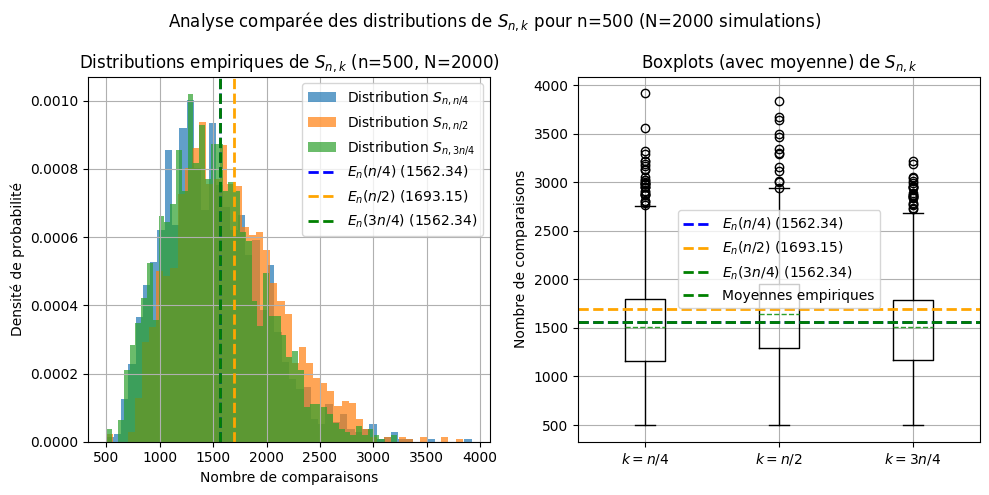

In [20]:
# Parameters for the simulation
n = 500 
N = 2000

# K values
k_q1 = n // 4
k_med = n // 2
k_q3 = 3 * (n // 4)

# Theoretical Means
E_n_q1 = E_nk(n, k_q1)
E_n_med = E_nk(n, k_med)
E_n_q3 = E_nk(n, k_q3)

# Values of S_n,k
Ss_q1 = np.array([simulate_quick_select_complexity(n, k_q1) for _ in range(N)])
Ss_med = np.array([simulate_quick_select_complexity(n, k_med) for _ in range(N)])
Ss_q3 = np.array([simulate_quick_select_complexity(n, k_q3) for _ in range(N)])

# Plotting
plt.figure(figsize=(10, 5))

# Histogram
plt.subplot(1, 2, 1)
plt.hist(Ss_q1, bins=50, density=True, label=f"Distribution $S_{{n, n/4}}$", alpha=0.7)
plt.hist(Ss_med, bins=50, density=True, label=f"Distribution $S_{{n, n/2}}$", alpha=0.7)
plt.hist(Ss_q3, bins=50, density=True, label=f"Distribution $S_{{n, 3n/4}}$", alpha=0.7)

plt.axvline(E_n_q1, color='blue', linestyle='--', linewidth=2, label=r"$E_n(n/4)$ " + f"({E_n_q1:.2f})")
plt.axvline(E_n_med, color='orange', linestyle='--', linewidth=2, label=r"$E_n(n/2)$ " + f"({E_n_med:.2f})")
plt.axvline(E_n_q3, color='green', linestyle='--', linewidth=2, label=r"$E_n(3n/4)$ " + f"({E_n_q3:.2f})")

plt.xlabel("Nombre de comparaisons")
plt.ylabel("Densité de probabilité")
plt.title(f"Distributions empiriques de $S_{{n,k}}$ (n={n}, N={N})")
plt.legend()
plt.grid(True)

# Boxplot with mean not median
plt.subplot(1, 2, 2)
plt.boxplot([Ss_q1, Ss_med, Ss_q3], showmeans=True, meanline=True, medianprops={'visible': False}, 
            tick_labels=[f"$k=n/4$", f"$k=n/2$", f"$k=3n/4$"])

# Add theoretical means as horizontal lines
plt.axhline(E_n_q1, color='blue', linestyle='--', linewidth=2, label=r"$E_n(n/4)$ " + f"({E_n_q1:.2f})")
plt.axhline(E_n_med, color='orange', linestyle='--', linewidth=2, label=r"$E_n(n/2)$ " + f"({E_n_med:.2f})")
plt.axhline(E_n_q3, color='green', linestyle='--', linewidth=2, label=r"$E_n(3n/4)$ " + f"({E_n_q3:.2f})")
# Dummy plot for empirical mean legend
plt.plot([], [], color='green', linestyle='--', linewidth=2, label='Moyennes empiriques')

plt.ylabel("Nombre de comparaisons")
plt.title(f"Boxplots (avec moyenne) de $S_{{n,k}}$")
plt.legend()
plt.grid(True)

plt.suptitle(f"Analyse comparée des distributions de $S_{{n,k}}$ pour n={n} (N={N} simulations)")
plt.tight_layout()

**Analyse & Commentaire**

L'analyse des distributions de $S_{n,k}$ (pour $n=500$) confirme l'analyse théorique de la section 4.2 :

1.  **Validation de l'Espérance $E_n(k)$ :** Les histogrammes et les boxplots montrent que les moyennes empiriques (lignes vertes pointillées) sont quasi-alignées avec les espérances théoriques respectives (lignes colorées pointillées) calculées par la formule asymptotique $E_n(k)$.

2.  **Validation du Coût Maximal de la Médiane :** Le graphique confirme que le cas $k=n/2$ (médiane, en orange) est le plus coûteux en moyenne. Sa distribution est visiblement décalée vers la droite (plus de comparaisons) par rapport aux distributions des quartiles ($k=n/4$ et $k=3n/4$).

3.  **Validation de la Symétrie :** Les distributions pour $k=n/4$ (bleu) et $k=3n/4$ (vert) sont quasi-identiques, tant dans leur position (moyenne) que dans leur forme (dispersion). Cela valide empiriquement la symétrie de la formule asymptotique : $E_n(k) = E_n(n-k)$ (pour $k=n/4$, $n-k=3n/4$).

4.  **Concentration :** Les trois distributions sont unimodales et fortement concentrées autour de leurs moyennes respectives. Les boîtes interquartiles (IQR) sont petites, indiquant que, quel que soit $k$, l'algorithme est fiable et ses performances sont prévisibles.

Nous avons maintenant validé l'algorithme QuickSelect (Las Vegas), qui est $O(n)$ *en moyenne*.

<!-- PAGE_BREAK -->

### 5. Conclusion et Ouvertures

#### Bilan des Analyses (Las Vegas)

Ce rapport s'est attelé à démontrer l'efficacité de la **randomisation** comme outil fondamental pour garantir la robustesse des algorithmes. En nous concentrant sur le paradigme **Las Vegas** et la famille Quicksort, nous avons pu quantifier précisément le gain de l'introduction de l'aléa, qui transforme un "pire cas" déterministe ($O(n^2)$), lié à la structure des données, en un événement probabiliste de faible espérance.

Nos analyses théoriques, systématiquement confrontées aux simulations empiriques, ont validé les résultats suivants :

* **Quicksort Randomisé (QS) :** L'analyse de l'espérance de la complexité (en comparaisons) a été menée à terme (Section 2.3), confirmant la formule exacte $E_n = 2(n+1)H_n - 4n$. Celle-ci correspond bien au comportement asymptotique $E_n \approx 2n\ln n - 2.85n + o(n)$. Nos simulations (Section 2.5) ont non seulement validé cette espérance, mais aussi suggéré une forte concentration : la dispersion (écart-type) observée est en $O(n)$, ce qui est asymptotiquement négligeable devant la moyenne en $O(n \log n)$.

* **Optimisation (Median-of-Three) :** Cette heuristique (Section 3) s'est révélée doublement efficace. D'une part, elle réduit drastiquement la probabilité de choisir un très mauvais pivot (le pire cas), la faisant passer de $O(1/n)$ à $O(1/n^2)$. D'autre part, l'analyse d'Ansatz (Section 3.2) a confirmé le gain asymptotique sur la moyenne, $E_D(n) \approx \frac{12}{7} n\ln(n) - 1.827n + o(n)$. Cela représente une amélioration de $\approx 14\%$ sur la constante $2$ du Quicksort standard. Les simulations (Section 3.3) ont validé ce gain et ont de plus révélé une **variance réduite**, rendant l'algorithme Median-of-Three non seulement plus rapide, mais aussi plus prévisible.

* **QuickSelect (Sélection) :** L'adaptation du partitionnement (Section 4) a démontré une complexité attendue linéaire $O(n)$. L'analyse fine via les variables indicatrices (Section 4.2) a fourni la formule asymptotique générale, dépendant du rang $k$ recherché :
$$E_n(k) = 2n\left(1+\ln\frac{n}{n-k}\right) + 2k\ln\frac{n-k}{k} + o(n)$$
Les simulations (Section 4.3) ont confirmé cette formule et ont illustré que le coût attendu est **maximal** lors de la recherche de la médiane ($k=n/2$, où $E_n(n/2) \approx 3.386 n + o(n)$) et qu'il est symétrique ($E_n(k) \approx E_n(n-k)$), comme l'ont montré nos tests $k=n/4$ et $k=3n/4$. Toutefois, la dispersion (écart-type) observée est en $O(n)$ (assez prononcée par rapport à $E_n$), confirmée par la simulation

---

#### Ouvertures

Ce travail ouvre la voie à plusieurs approfondissements essentiels :

* **Le Paradigme Monte-Carlo :** Il serait pertinent de s'attaquer au paradigme Monte-Carlo (résultat approximatif, temps borné). L'analyse de l'**algorithme de Karger** [[1]](#ref1) pour la coupe minimale, serait un cas d'étude fascinant, nécessitant de calculer non pas une espérance de coût, mais une probabilité de succès (ex: $P(succ \ge 2/n^2)$) et les techniques d'**amplification** (répétition) nécessaires pour la rendre fiable.

* **Le Coût des Permutations (Swaps) :** Notre analyse s'est focalisée sur les comparaisons. Une ouverture serait d'étudier le nombre de **permutations** comme variable aléatoire. Par souci de concision et parce que ce coût est **extrêmement dépendant de l'implémentation** de la procédure de partitionnement (Lomuto, Hoare, etc.), nous ne l'avons pas traité, mais cela reste une piste d'optimisation cruciale en pratique.

* **Approfondissements sur la Sélection et la Distribution :** Nous avons montré que QuickSelect est $O(n)$ *en moyenne*. Une piste serait d'analyser l'algorithme déterministe **BFPRT (Median-of-Medians)**, qui garantit $O(n)$ *dans tous des cas*, sans faire recours à l'aléa. Enfin, l'étude pourrait être étendue à la **variance** (que nos simulations suggèrent être en $O(n^2)$ pour Quicksort et $O(n)$ pour QuickSelect) et à la convergence de la variable aléatoire normalisée vers une **distribution limite**.

---
**Références :**

<a id="ref1"></a>[1] Mitzenmacher, M., & Upfal, E. (2005). *Probability and Computing*. Cambridge University Press.